In [197]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
#from lwautils import lwa_arx 
import pandas as pd
from cr_functions import *
from cr_data_inspection_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st
from lwa_antpos import mapping
import os

# Notebook overview
This notebook runs threshold scans to count trigger and veto rates for one subarray.

NOTE ABOUT THIS VERSION:  

## Contents
### Functions to calculate delays
This section is commented out because I'm using Jack's script for setting delays, but I want to keep my code in case I want to do a comparison in the future.
My approach was to read delays exported from a calibration table, which was made by running the casa task gaincal on Cygnus A visibilities, and then calculate the number of clock cycles of delay to apply to each FPGA channel.
### Load firmware and initialize
### Send a snapshot and inspect 
Sometimes I skip this section so note that the snapshot plotted may be old.
### Individual Antenna Threshold Scan
Vary the voltage threshold and count the number of times each antenna exceeds that threshold.
### How often are antennas saturating?
### Single-board threshold scan, no veto
Vary the minimum number of antennas to trigger and the voltage threshold and count the trigger rate.

### Single-board threshold scan with veto

### Window length scan
Explore the dependence of trigger rate on window length.


# Calculate Delays

In [198]:
'''
def delay_dictionary_from_textfile(fname):
    #builds a dictionary of delays where the keys are antenna names in the format "LWA-089A"
    #input is a text file exported from plotms, the delay calibration table is the plotms input and the plotms "yaxis" is delay
    data = pd.read_csv(fname, sep=" ")
    data.columns = ['x', 'y', 'chan', 'scan', 'field', 'ant1', 'ant2', 'ant1name', 'ant2name', 'time', 'freq', 'spw', 'corr', 'offset', 'currchunk', 'irel', 'placeholder']
    delaydictionary={}
    for i in range(1,len(data)):
        delay=data['y'][i]
        longname=str(data['ant1name'][i])
        if data['corr'][i]=='R':
            name="LWA-"+longname[3:6]+'A'
        elif data['corr'][i]=='L':
            name="LWA-"+longname[3:6]+'B'
        delaydictionary[name]=delay
    return delaydictionary


def clock_cycle_delay_array_from_dictionary(delay_dictionary):
    #calculate delays in number of clock cycles to write to each signal stream of each SNAP2
    #input is a dictionary with antenna names as keys (in format "LWA-089A") and values are delay in nanoseconds
    delays_array=np.ones((64,11),dtype=int)  #array to hold delay values for 11 SNAP2s and 64 channels each.
    for name in delay_dictionary.keys():
        delay_ns=float(delay_dictionary[name])
        delay_int=int(delay_ns*1e-9*1.97e8)
        snap2,channel=mapping.antpol_to_fpga(name[:-1], name[-1])
        #print(snap2,channel)
        delays_array[channel,snap2-1]+=delay_int
    most_negative_delay=np.min(delays_array)
    delays_array+=-1*most_negative_delay  #delays to write to block cannot be zero, so they are all relative to the antenna that is most ahead of the reference antenna
    return delays_array'''

'\ndef delay_dictionary_from_textfile(fname):\n    #builds a dictionary of delays where the keys are antenna names in the format "LWA-089A"\n    #input is a text file exported from plotms, the delay calibration table is the plotms input and the plotms "yaxis" is delay\n    data = pd.read_csv(fname, sep=" ")\n    data.columns = [\'x\', \'y\', \'chan\', \'scan\', \'field\', \'ant1\', \'ant2\', \'ant1name\', \'ant2name\', \'time\', \'freq\', \'spw\', \'corr\', \'offset\', \'currchunk\', \'irel\', \'placeholder\']\n    delaydictionary={}\n    for i in range(1,len(data)):\n        delay=data[\'y\'][i]\n        longname=str(data[\'ant1name\'][i])\n        if data[\'corr\'][i]==\'R\':\n            name="LWA-"+longname[3:6]+\'A\'\n        elif data[\'corr\'][i]==\'L\':\n            name="LWA-"+longname[3:6]+\'B\'\n        delaydictionary[name]=delay\n    return delaydictionary\n\n\ndef clock_cycle_delay_array_from_dictionary(delay_dictionary):\n    #calculate delays in number of clock cycles t

# Load firmware
Don't forget to do 'crontab -e' on GPU 09 and comment out the RFI monitor tasks, so that they won't try to read the SNAP2 while it's programming.  And restart the RFI monitor after programming.

In [199]:
fpgfile="/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-09-20_1316.fpg"

brdname='snap05'
#load firmware and initialize etc
brd=snap2_fengine.Snap2Fengine(brdname)
brd.program(fpgfile)


casperbrd = casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport)

2023-01-15 04:23:18,969 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 0
2023-01-15 04:23:19,206 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 1
2023-01-15 04:23:19,220 - lwa_f.snap2_fengine:snap05 - INFO - Loading firmware /home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-09-20_1316.fpg to snap05
2023-01-15 04:23:41,670 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 0
2023-01-15 04:23:41,909 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 1


In [200]:
brd.initialize(read_only=False)
brd.sync.arm_sync()
brd.sync.sw_sync()

2023-01-15 04:24:08,238 - lwa_f.snap2_fengine:snap05 - INFO - Initializing block (writable): fpga
2023-01-15 04:24:08,240 - lwa_f.snap2_fengine:snap05 - INFO - Initializing block (writable): adc
2023-01-15 04:24:08,245 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 board 0: Setting clock source to 1
2023-01-15 04:24:08,254 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 board 1: Setting clock source to 1
2023-01-15 04:24:08,261 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 1 board 0: Setting clock source to 1
2023-01-15 04:24:08,267 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 1 board 1: Setting clock source to 1
2023-01-15 04:24:21,151 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 board 0 clock rates: [490715979, 98190720, 98231975, 0, 0]
2023-01-15 04:24:21,152 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 board 0: MMCM locked
2023-01-15 04:24:22,162 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 board 1 clock rates: [490698393, 98192484, 98236137, 98282190, 0]
2023-01-

100% (64 of 64) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


2023-01-15 04:24:43,436 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 data lane delays:
[[328, 320, 328, 312, 320, 320, 320, 312], [328, 328, 320, 312, 320, 312, 312, 320], [264, 264, 272, 272, 272, 264, 264, 272], [312, 312, 312, 304, 304, 304, 304, 296], [288, 280, 288, 280, 280, 288, 280, 280], [256, 264, 272, 256, 264, 256, 256, 256], [336, 312, 312, 312, 312, 328, 312, 312], [328, 328, 328, 328, 328, 336, 336, 328]]
2023-01-15 04:24:43,437 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 data lane slacks:
[[32, 32, 32, 32, 32, 32, 32, 32], [32, 40, 32, 32, 32, 32, 32, 32], [32, 32, 40, 40, 40, 32, 40, 32], [40, 32, 40, 40, 32, 32, 40, 32], [32, 40, 32, 32, 32, 32, 32, 32], [32, 40, 32, 32, 40, 32, 32, 32], [32, 32, 32, 32, 32, 32, 32, 32], [32, 32, 32, 32, 32, 24, 24, 32]]
2023-01-15 04:24:43,438 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXX
2023-01-15 04:24:43,439 - lwa_f.blocks.block:snap05 - INF

2023-01-15 04:24:43,470 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXX
2023-01-15 04:24:43,470 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXX
2023-01-15 04:24:43,471 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXX
2023-01-15 04:24:43,472 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXX
2023-01-15 04:24:43,472 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXX
2023-01-15 04:24:43,473 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXX
2023-01-15 04:24:43,473 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


2023-01-15 04:25:01,644 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 1 data lane delays:
[[264, 272, 264, 272, 264, 264, 256, 272], [232, 232, 232, 232, 224, 248, 232, 224], [256, 256, 256, 272, 256, 264, 256, 248], [256, 272, 256, 264, 256, 264, 256, 256], [312, 312, 312, 320, 320, 312, 312, 312], [224, 224, 224, 224, 224, 216, 232, 224], [272, 264, 264, 272, 264, 264, 256, 264], [248, 248, 256, 248, 256, 256, 248, 248]]
2023-01-15 04:25:01,644 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 1 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 32, 40, 40, 32], [40, 40, 40, 40, 32, 40, 32, 40], [32, 40, 40, 40, 40, 40, 32, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 32, 32, 40, 40, 32, 40, 40], [40, 40, 32, 32, 40, 40, 32, 32], [32, 32, 40, 32, 40, 40, 32, 40]]
2023-01-15 04:25:01,645 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXX
2023-01-15 04:25:01,646 - lwa_f.blocks.block:snap05 - INF

2023-01-15 04:25:01,684 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2023-01-15 04:25:01,684 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXX
2023-01-15 04:25:01,688 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2023-01-15 04:25:01,689 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2023-01-15 04:25:01,689 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2023-01-15 04:25:01,690 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2023-01-15 04:25:01,691 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

### Set delays
I'm not using this this time because I'm setting the delays with Jack's script, by doing:

(casa) ubuntu@lxdlwacr:~/proj/lwa-shell/caltech-lwa/control_sw/scripts$ ./lwa_load_delays.py ../config/cable_delays.csv 

In [86]:
'''#calculate delays
delaytextfile='/home/ubuntu/kp/delays/20220420_184251_57MHz.delays.txt'
delay_dictionary=delay_dictionary_from_textfile(delaytextfile)
delays_array=clock_cycle_delay_array_from_dictionary(delay_dictionary)

#set delays
delayblock=blocks.delay.Delay(casperbrd, 'delay', n_streams=64, logger=None)
delayblock.initialize()
snap2index=6 #this is board 7 if it starts with 1, so 0-index means it's 6
for i in range(64):
    z=delays_array[i,6]
    delayblock.set_delay(i,z)
'''



# Send snapshot

In [201]:
boardnumber = int(brdname[-2:])

In [227]:
#prepare to send a snapshot
setup_data_source(casperbrd,"adc")
casperbrd.write_int('set_counter_test_signal',0) #make sure the counter before the delay block isn't set
setup_ethernet(brdname,casperbrd,fpgfile,'lwacr',100)
setvalue(casperbrd,'brd_id','cr_registers.xlsx',boardnumber)

#enable ethernet
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)
#send trigger
software_trigger(casperbrd,1)

getvalue(casperbrd,"count_triggers","cr_registers.xlsx")


Data source set to adc
------------------------
snap05:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:05:05:05
Gateway:  0.0.0.1
IP:  10.41.0.205
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 58: MAC: 04:3F:72:DF:C2:F8
Setting wait between packets to 100
Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 22848 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


4

In [215]:
print(brdname)

snap05


Below I plot the snapshot.

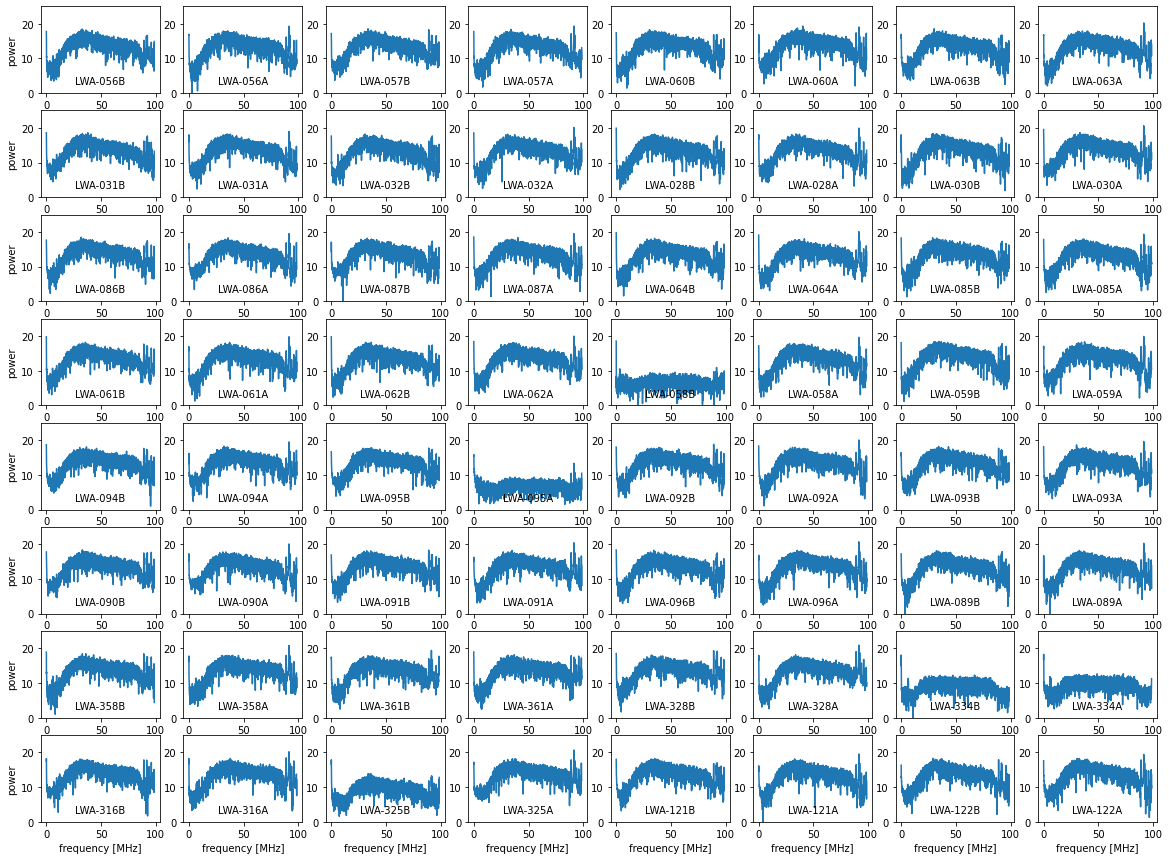

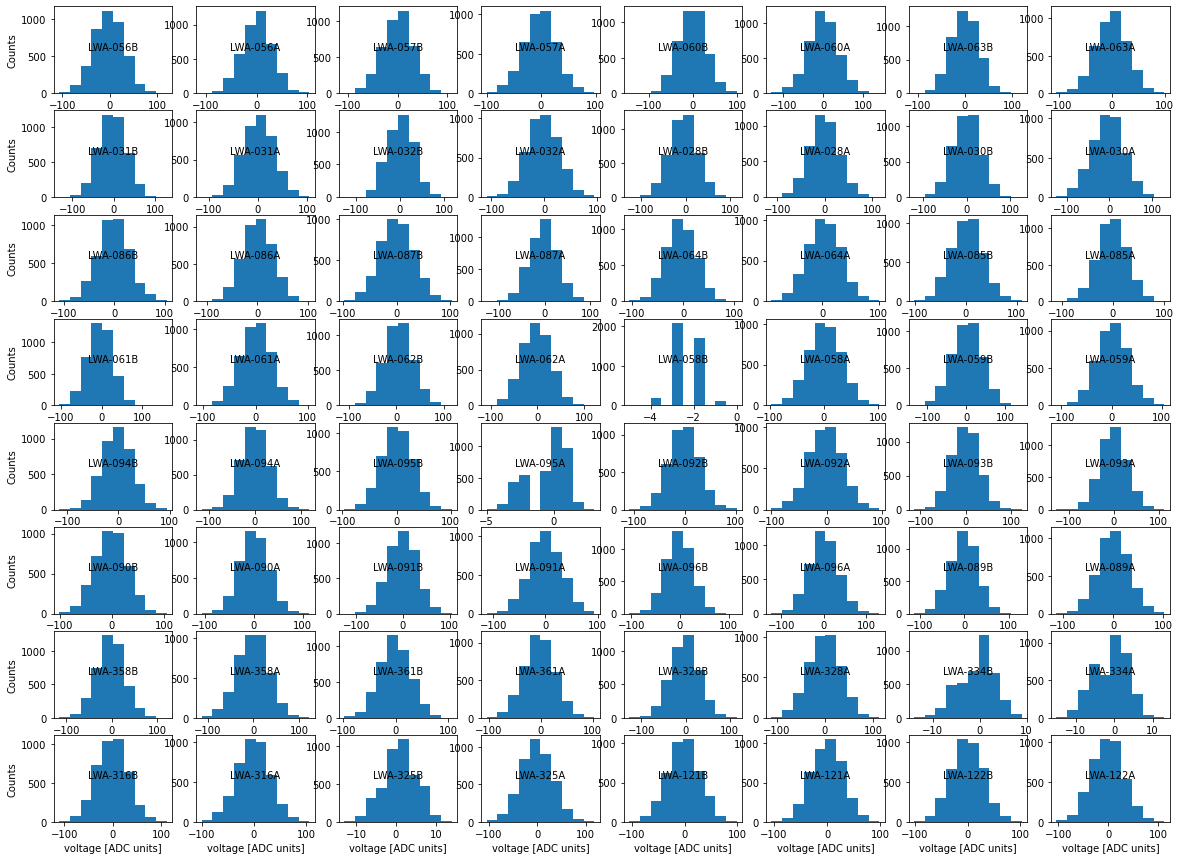

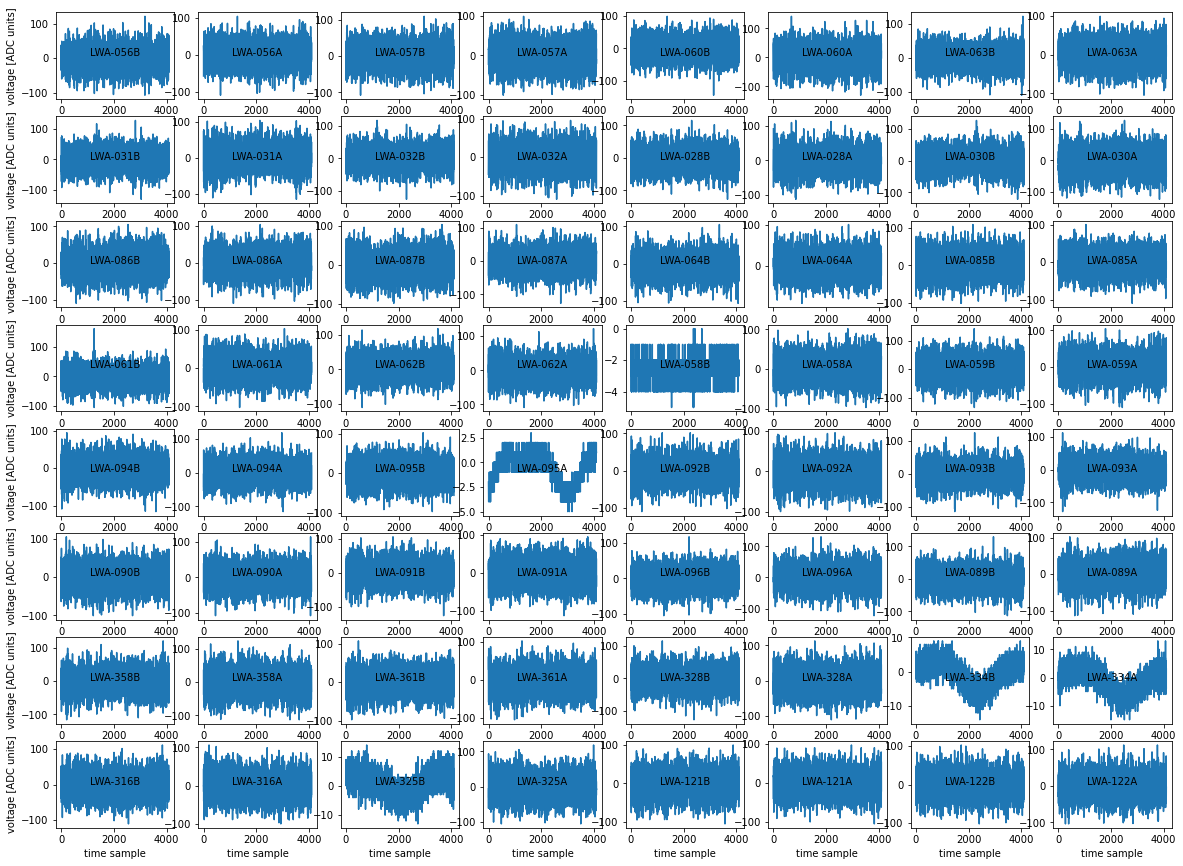

In [230]:
snapshotfname1='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/testing2023Jan3/single_board_snapshot1672785489.8310494_0_8.npy'
snapshotfname2='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/testing2023Jan3/single_board_snapshot1672787590.631033_0_0.npy'
snapshot1_5_2022='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/tests2023Jan5/single_board_snapshot1672945642.1186545_0_0.npy'
snapshot1_5_2022b='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/tests2023Jan5/single_board_snapshot1672948742.6416194_0_210.npy'
snapshot1_14_2022='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1673757330.6001053_0_0.npy'
snapshot1_14_2022b='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1673760392.3317268_0_179.npy'

boardnumber=int(brdname[4:])
single_board_snapshot_summary_plots(snapshot1_14_2022b,boardnumber)


The veto antennas in this subarray are 328, 325, 334, and 316. 328 has the prototype laser driver.  Power high on 316b, 328A, looks like those saturate. The others look ok.


In [267]:
str(time.time())

'1673761984.0646827'

# Individual antenna threshold scan

In [205]:
setup_data_source(casperbrd,"adc")
thresholds = 4*np.asarray(range(128))
vthresholds = np.flip(thresholds)
results_core = np.zeros((64,128))
results_veto = np.zeros((64,128))

for i in range(len(thresholds)):
    t_c = thresholds[i]
    t_v = vthresholds[i]
    setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2))
    setvalue(casperbrd,"veto_power_thresh","cr_registers.xlsx",int(t_v**2))
    time.sleep(2.75)  #have to wait for it to update
    core,veto = read_threshold_rates(casperbrd)
    results_core[:,i] = core
    results_veto[:,i] = veto

#np.save('/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/tests2023Jan5/individual_antenna_thresh_scan_brd9_c',results_core)
#np.save('/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/tests2023Jan5/individual_antenna_thresh_scan_brd9_v',results_veto)

Data source set to adc


LWA-030A
Fit Core
[184.19087488]
[[22.19816471]]
Fit Veto
[185.03085406]
[[18.30836318]]


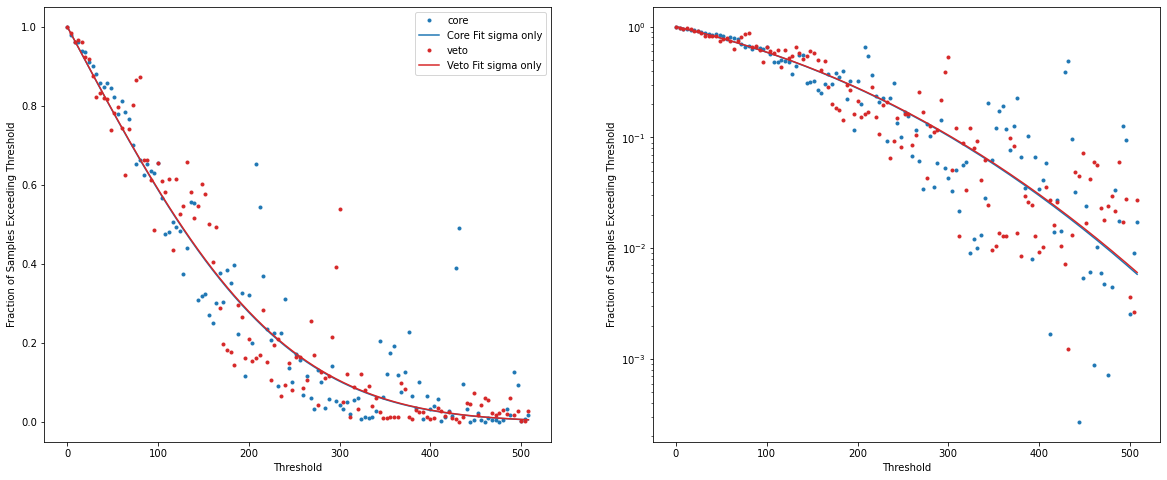

LWA-030B
Fit Core
[172.11862453]
[[15.40099084]]
Fit Veto
[177.79788116]
[[18.43088635]]


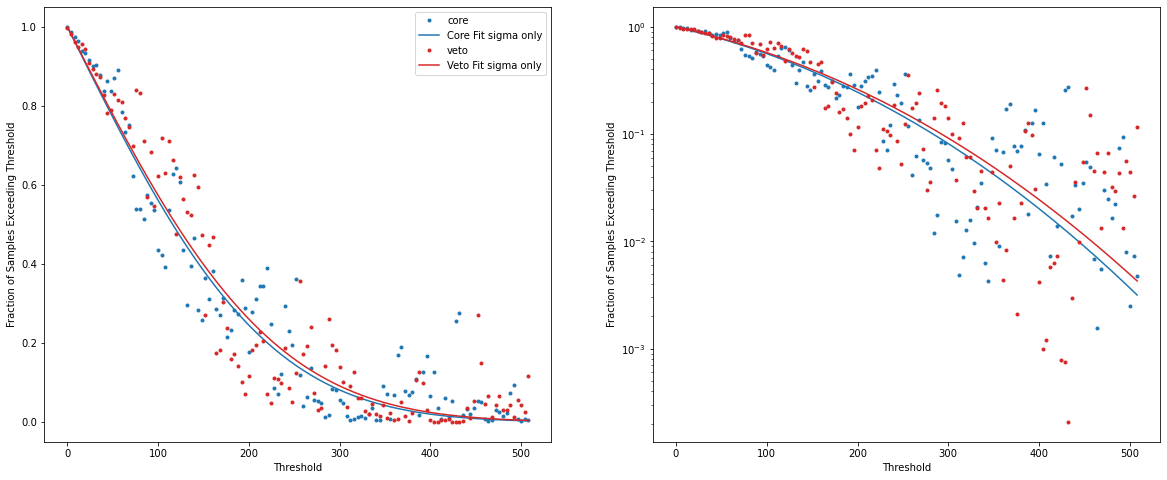

LWA-028A
Fit Core
[179.46383452]
[[23.98374839]]
Fit Veto
[182.70297741]
[[21.22067289]]


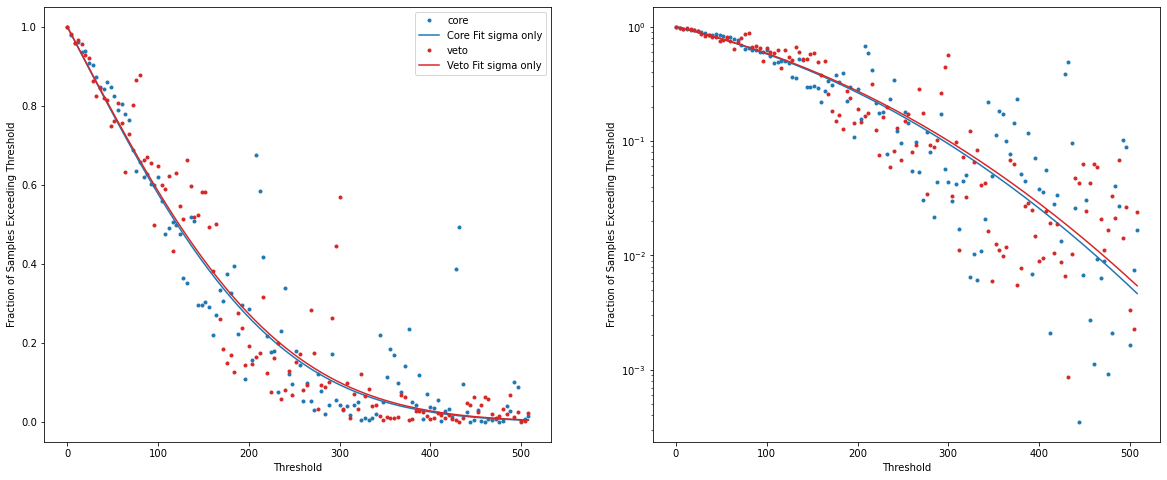

LWA-028B
Fit Core
[165.80638475]
[[13.02642373]]
Fit Veto
[171.65289223]
[[16.08182344]]


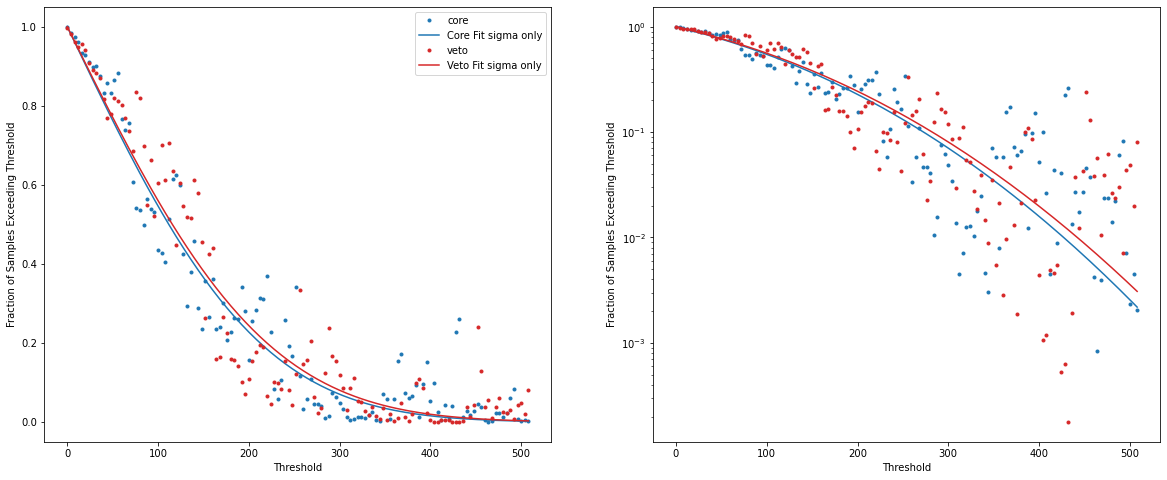

LWA-032A
Fit Core
[178.11635973]
[[24.9379838]]
Fit Veto
[182.00940524]
[[22.57645671]]


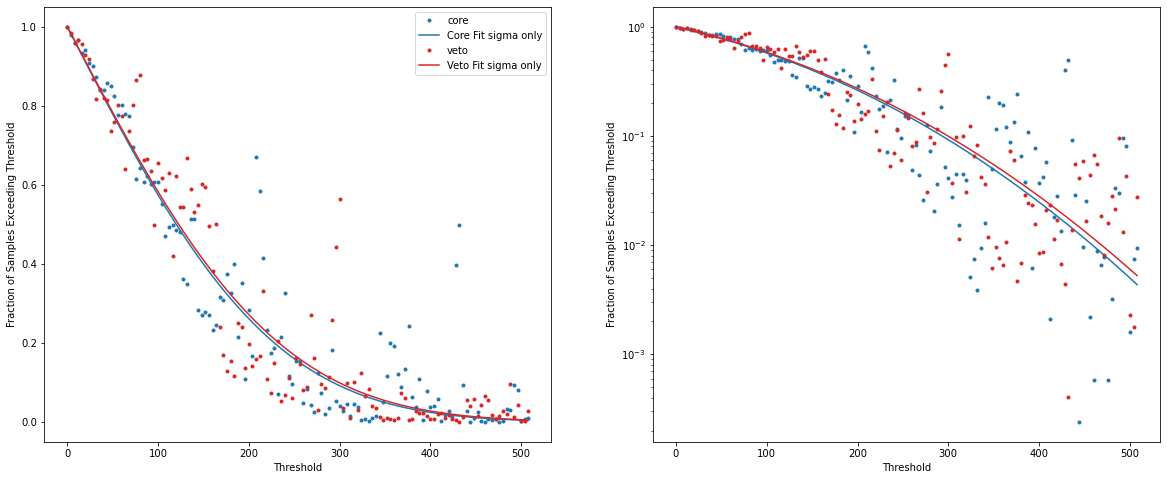

LWA-032B
Fit Core
[165.08864674]
[[14.10915026]]
Fit Veto
[171.71627907]
[[17.55233407]]


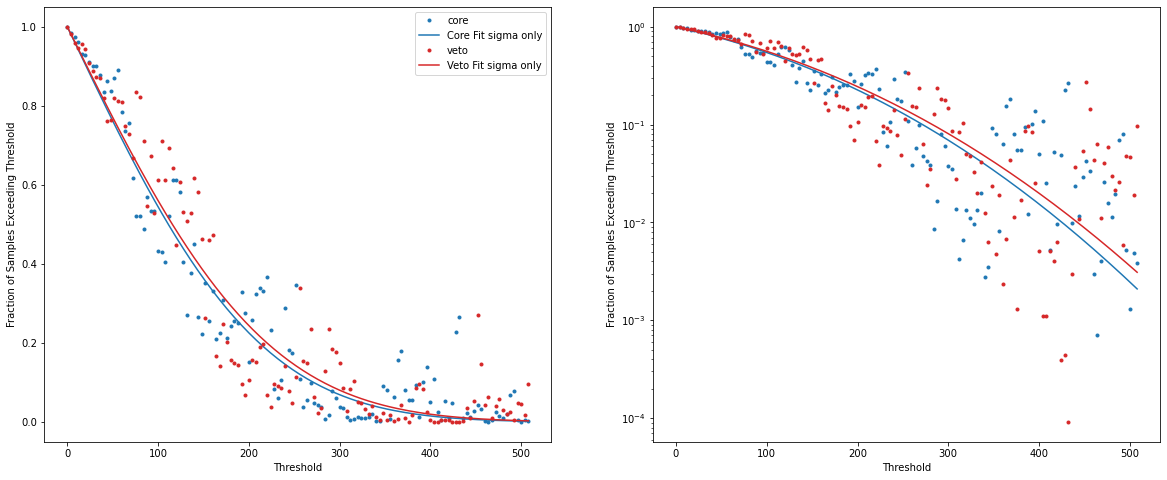

LWA-031A
Fit Core
[177.94690145]
[[24.86825761]]
Fit Veto
[181.78859011]
[[22.36791593]]


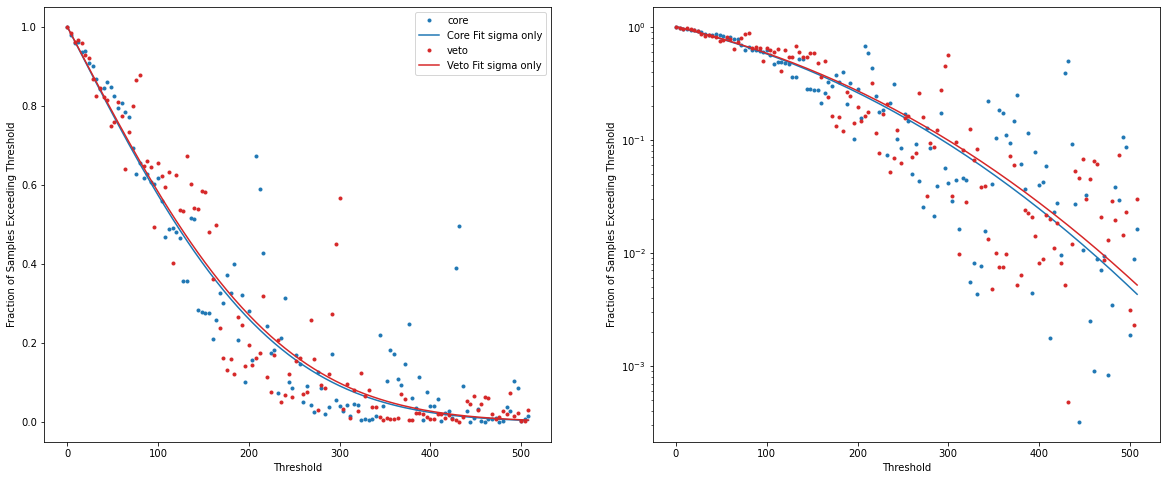

LWA-031B
Fit Core
[167.06811864]
[[14.63479599]]
Fit Veto
[174.57286764]
[[18.25020597]]


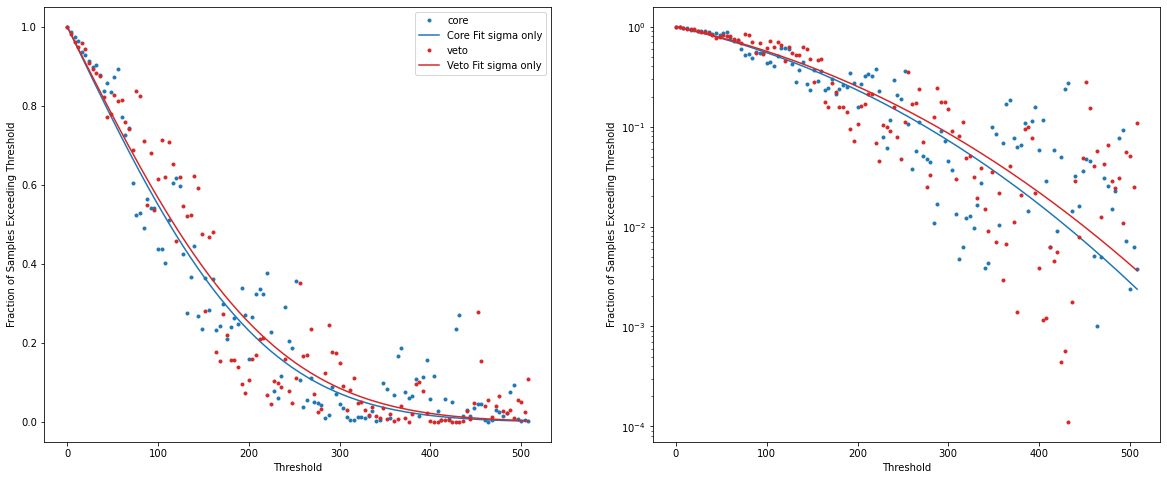

LWA-063A
Fit Core
[167.04504974]
[[23.38084873]]
Fit Veto
[174.00805712]
[[22.66709622]]


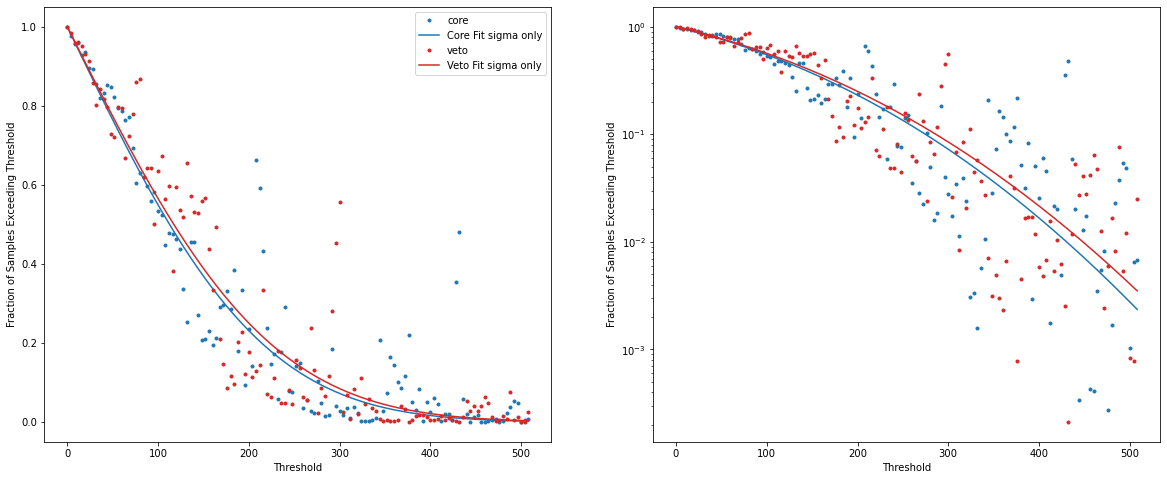

LWA-063B
Fit Core
[152.58425124]
[[11.72749757]]
Fit Veto
[161.09488331]
[[15.19263794]]


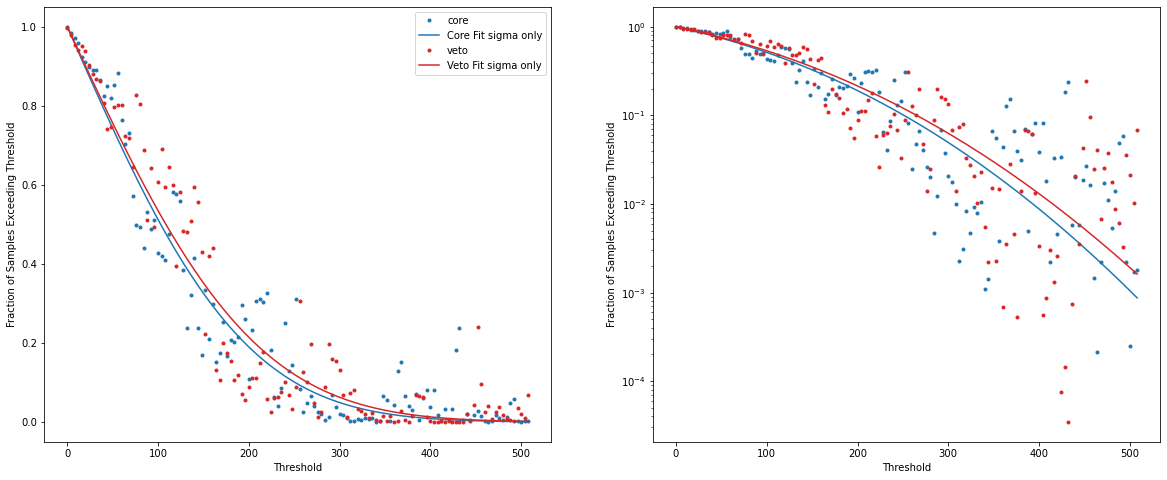

LWA-060A
Fit Core
[157.68474758]
[[20.30559127]]
Fit Veto
[168.06659001]
[[19.93438496]]


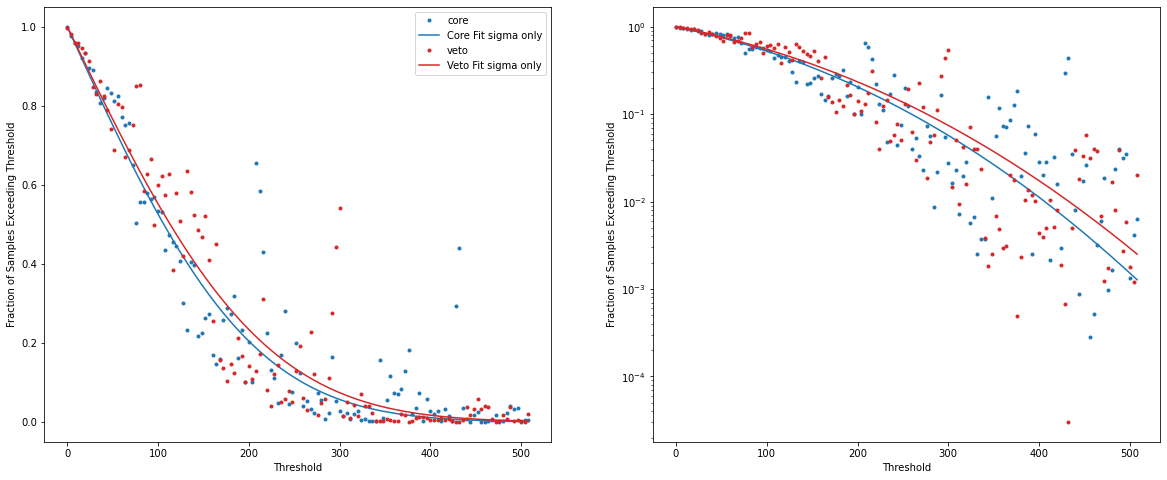

LWA-060B
Fit Core
[154.50534204]
[[11.13139817]]
Fit Veto
[162.43152742]
[[14.10459278]]


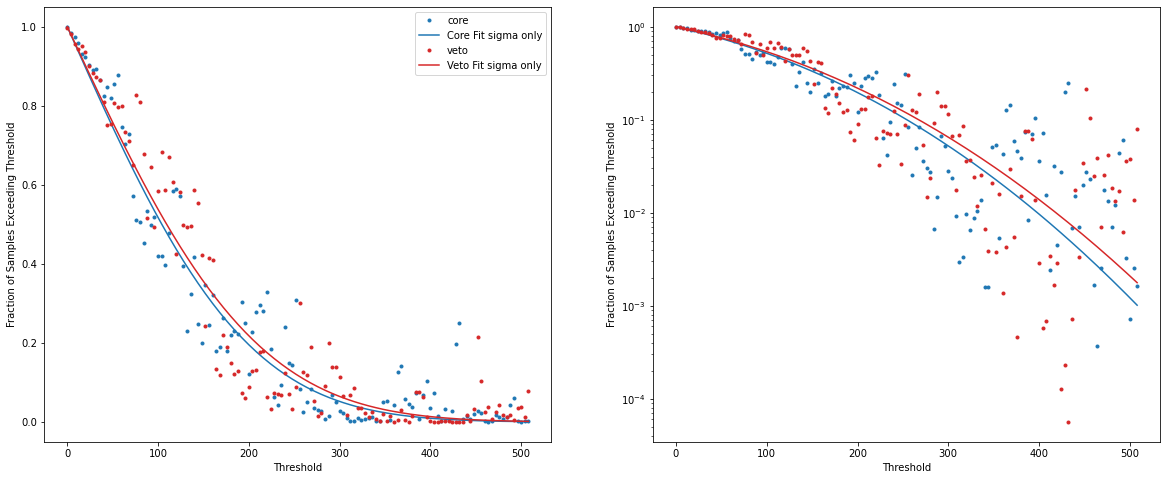

LWA-057A
Fit Core
[166.41836592]
[[20.09007314]]
Fit Veto
[172.39578887]
[[19.33874189]]


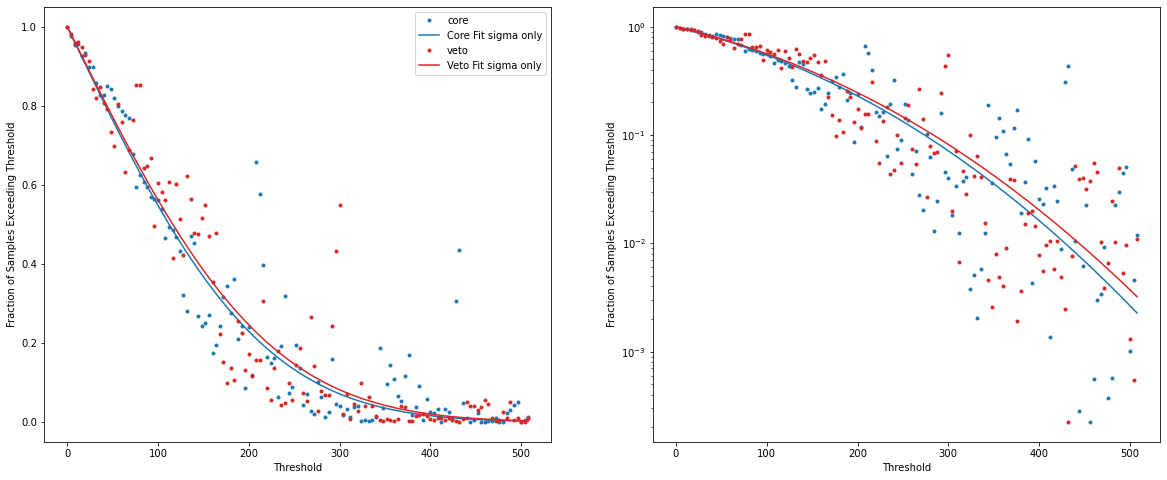

LWA-057B
Fit Core
[157.65377627]
[[11.55962956]]
Fit Veto
[164.63639915]
[[14.16838828]]


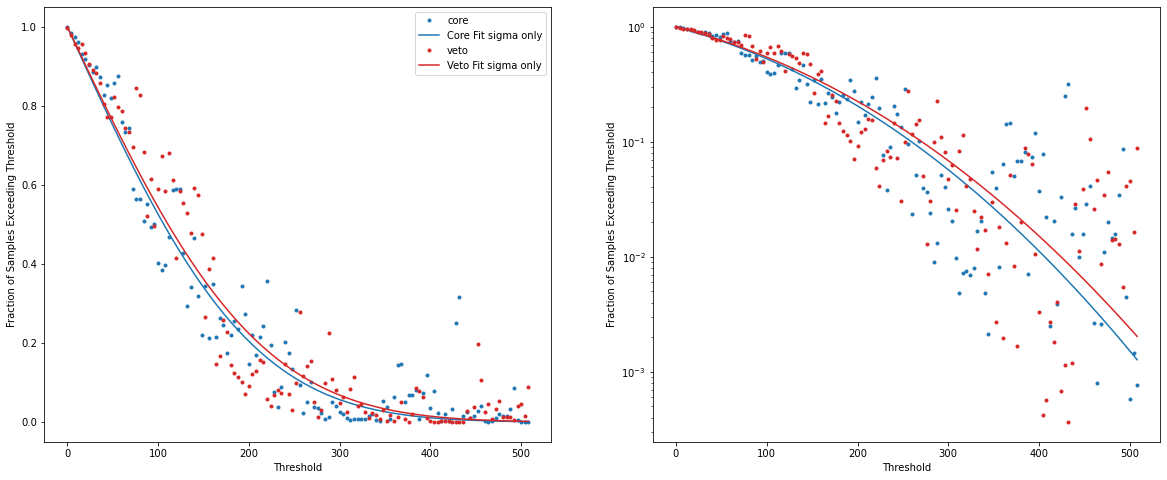

LWA-056A
Fit Core
[161.54044706]
[[19.57466844]]
Fit Veto
[169.29511702]
[[18.92285172]]


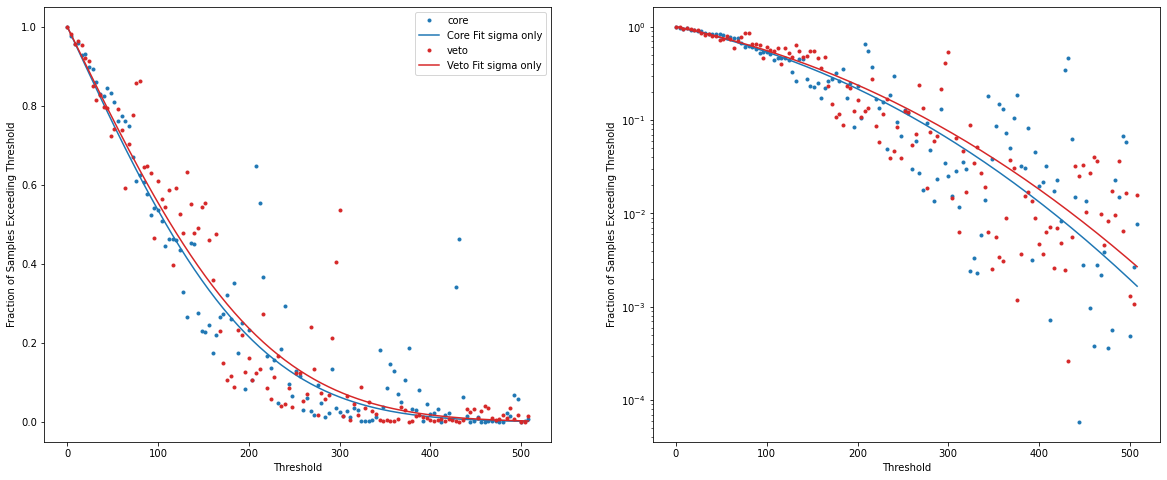

LWA-056B
Fit Core
[174.45393192]
[[15.70921021]]
Fit Veto
[179.9409664]
[[18.69395162]]


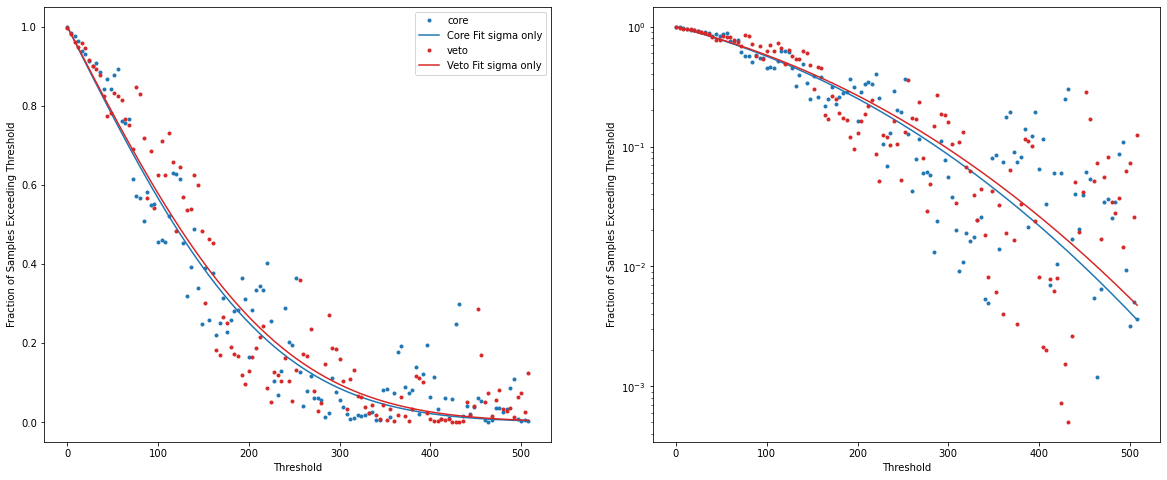

LWA-059A
Fit Core
[165.54556702]
[[20.81725563]]
Fit Veto
[172.4869656]
[[19.72001828]]


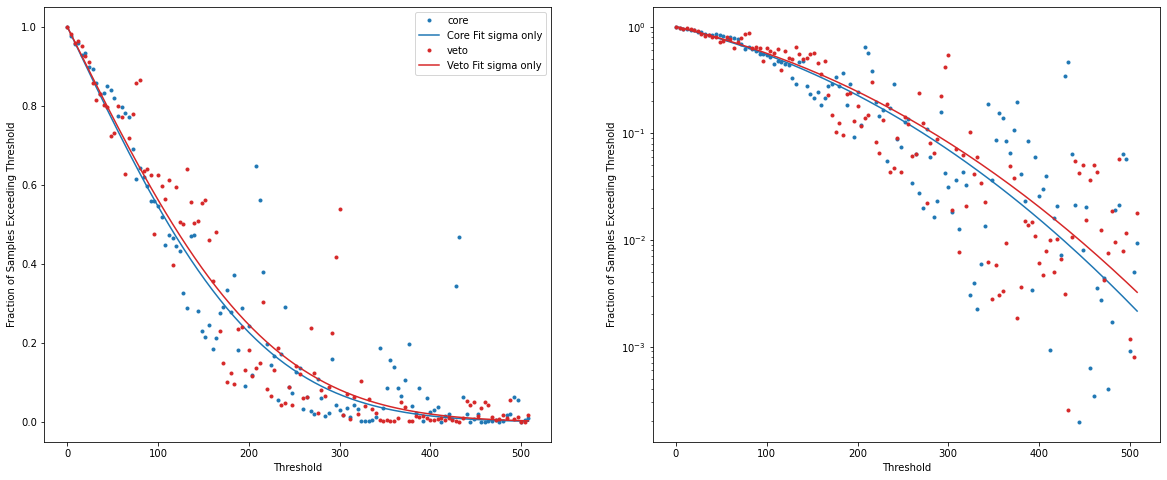

LWA-059B
Fit Core
[211.11631704]
[[25.45342815]]
Fit Veto
[212.53099262]
[[27.05906159]]


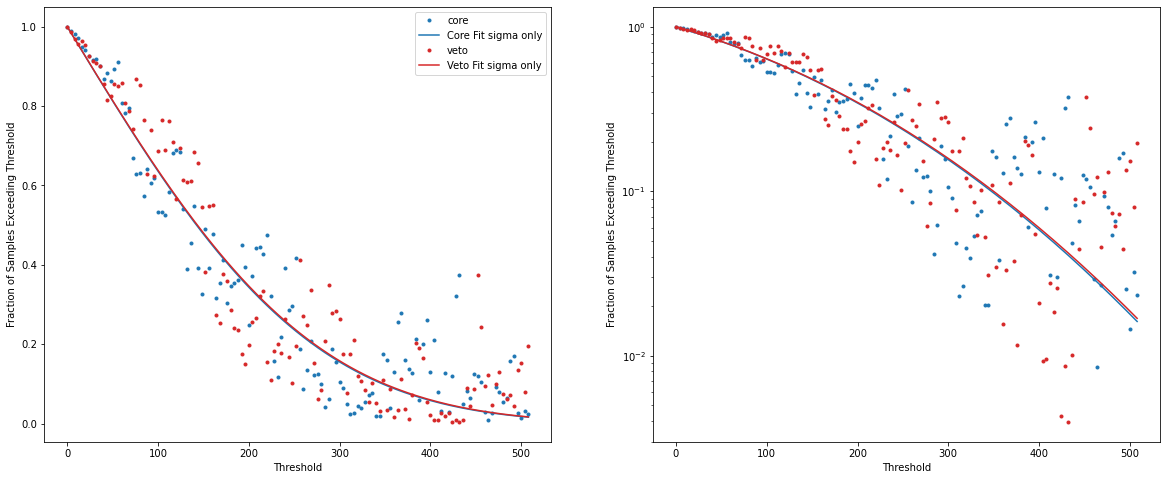

LWA-058A
Fit Core
[170.1013233]
[[22.21252756]]
Fit Veto
[175.80195686]
[[20.19267175]]


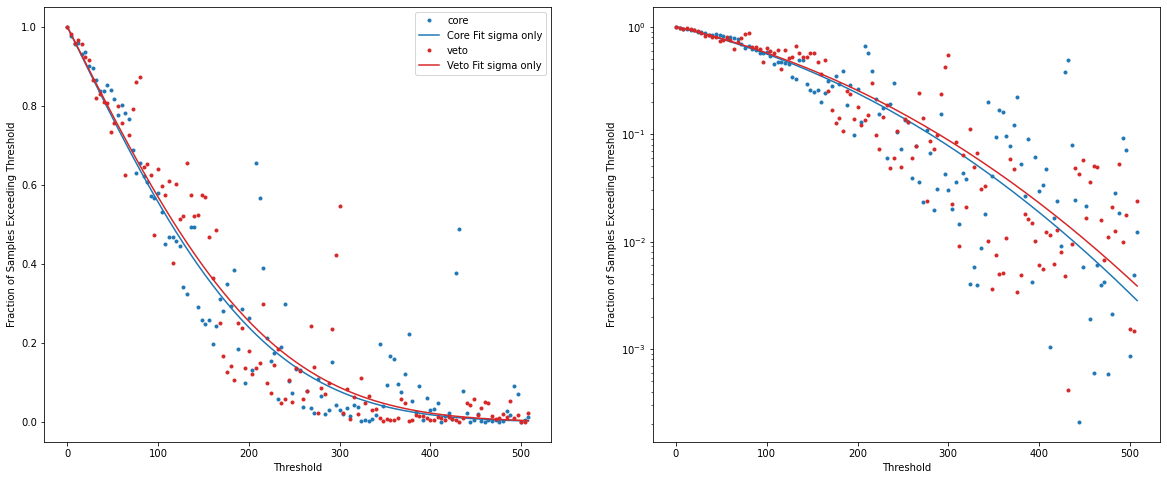

LWA-058B
Fit Core
[2.7329131]
[[0.00336767]]
Fit Veto
[2.67038866]
[[0.00231587]]


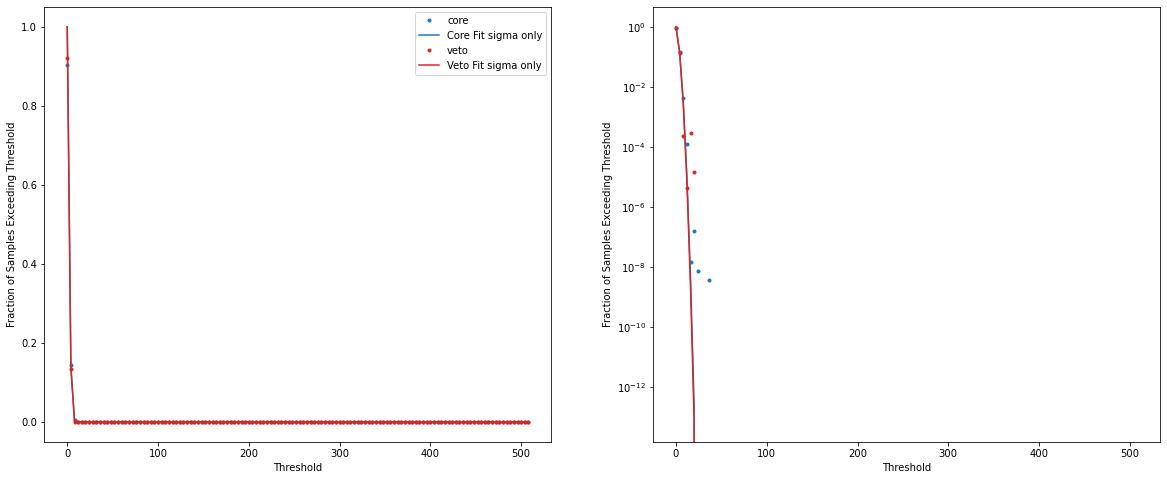

LWA-062A
Fit Core
[168.98224765]
[[21.5869236]]
Fit Veto
[174.4843231]
[[20.48401548]]


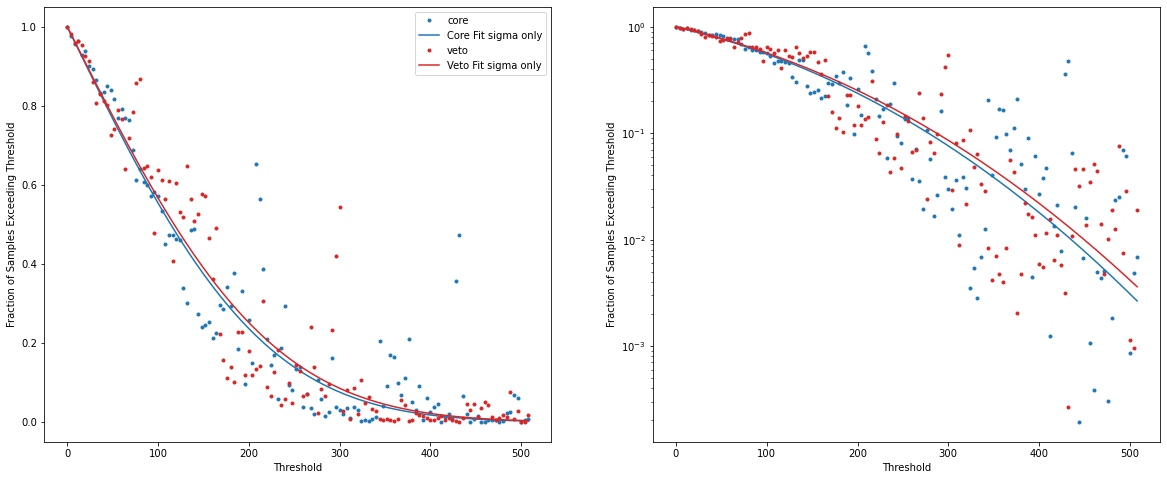

LWA-062B
Fit Core
[161.5643886]
[[12.81841931]]
Fit Veto
[168.83889781]
[[16.44119159]]


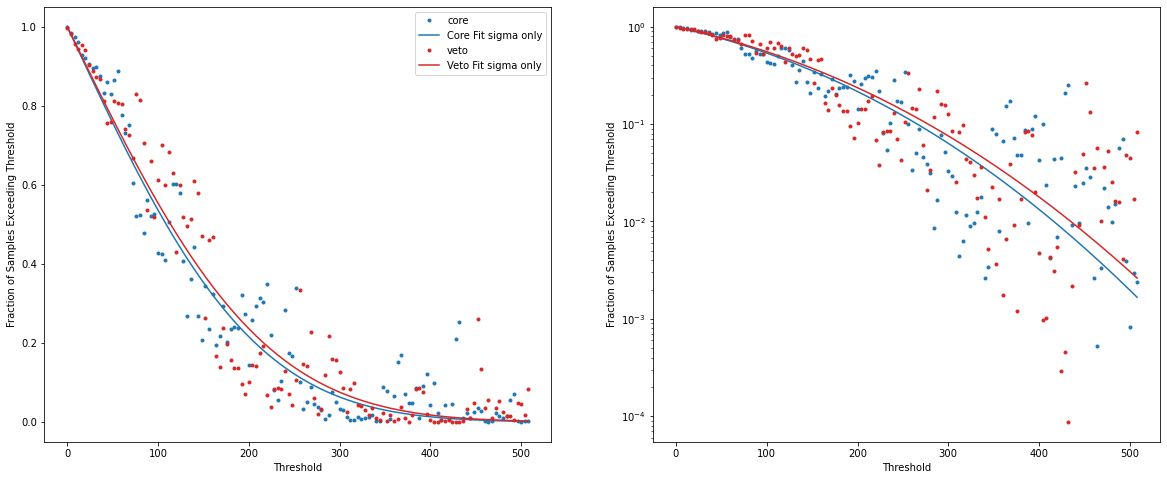

LWA-061A
Fit Core
[162.58369099]
[[20.39142766]]
Fit Veto
[169.75441214]
[[19.59301591]]


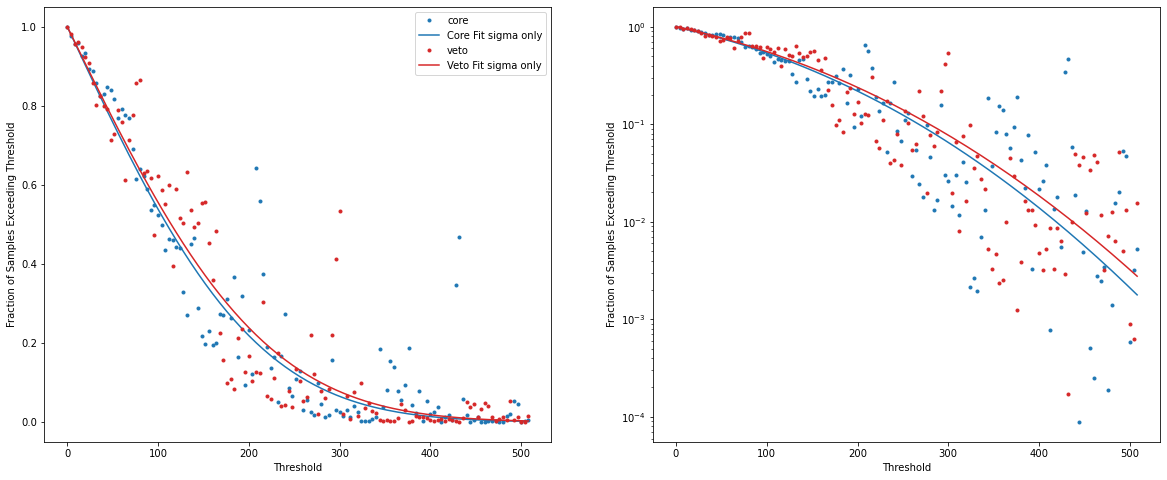

LWA-061B
Fit Core
[169.64753786]
[[17.14424812]]
Fit Veto
[176.14667126]
[[20.11102298]]


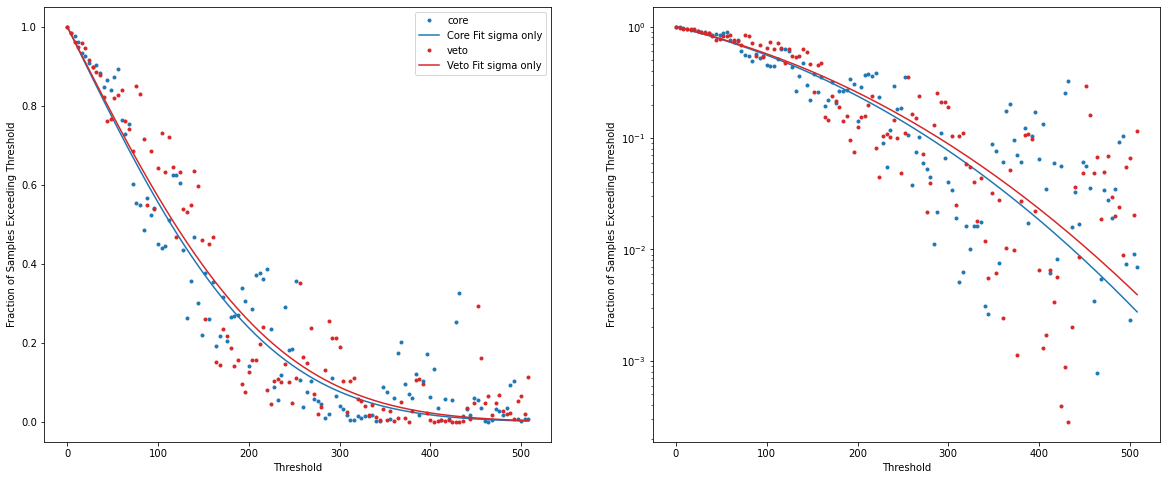

LWA-085A
Fit Core
[178.91562058]
[[25.40602538]]
Fit Veto
[185.61750486]
[[22.09959017]]


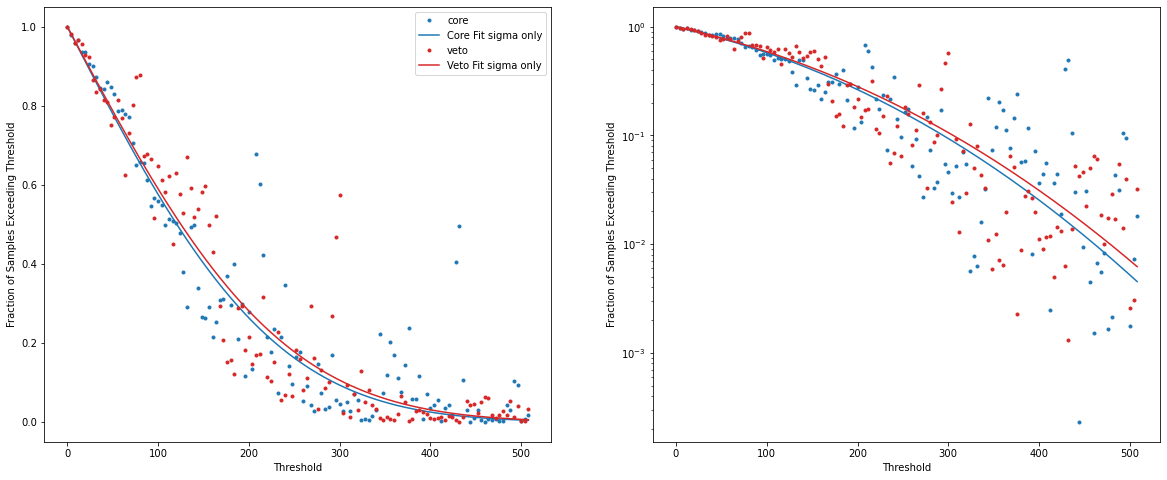

LWA-085B
Fit Core
[169.15425397]
[[13.74434194]]
Fit Veto
[176.21432092]
[[16.34456377]]


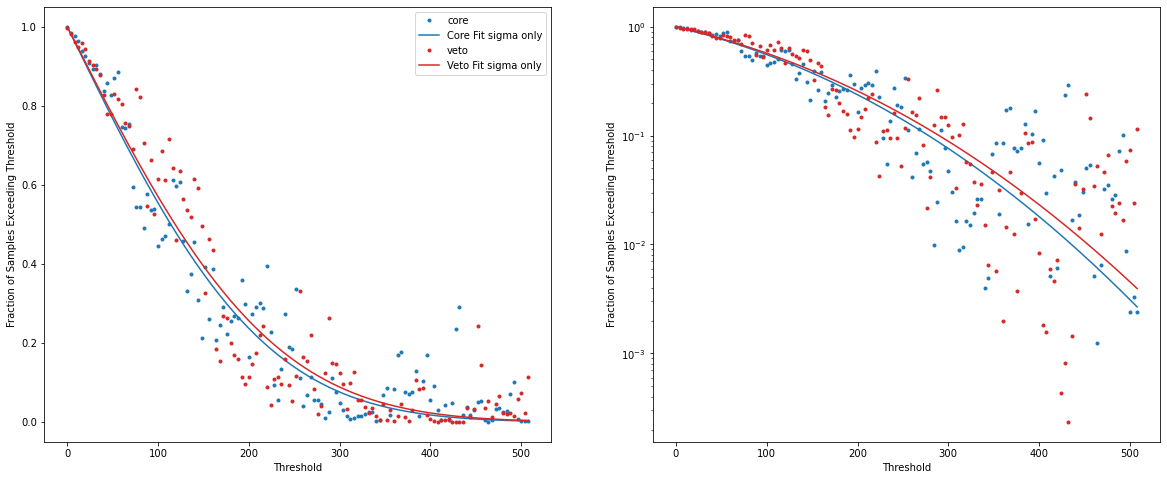

LWA-064A
Fit Core
[163.41829848]
[[20.47767541]]
Fit Veto
[169.87060504]
[[19.95457452]]


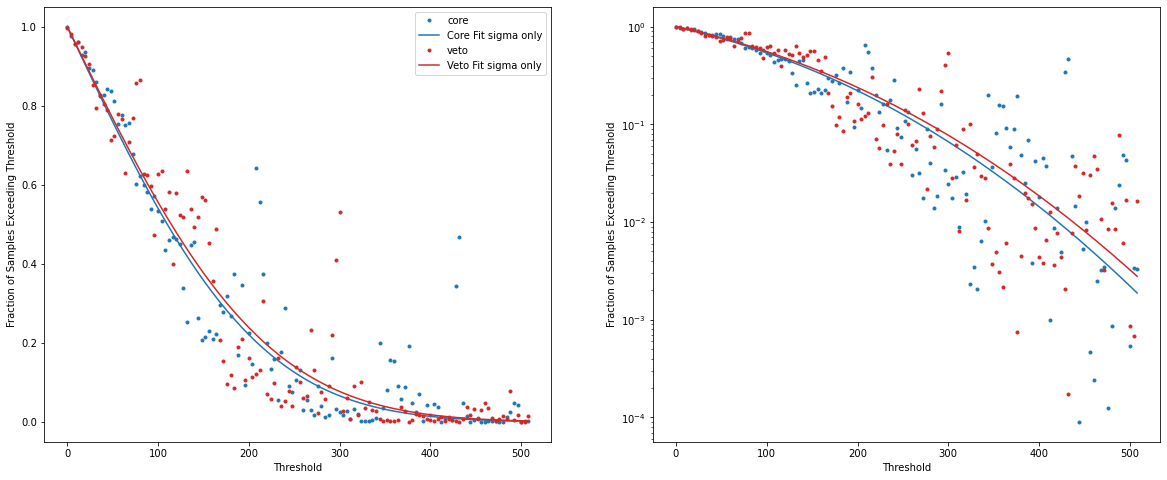

LWA-064B
Fit Core
[149.2186552]
[[10.87141696]]
Fit Veto
[158.57980655]
[[14.05468303]]


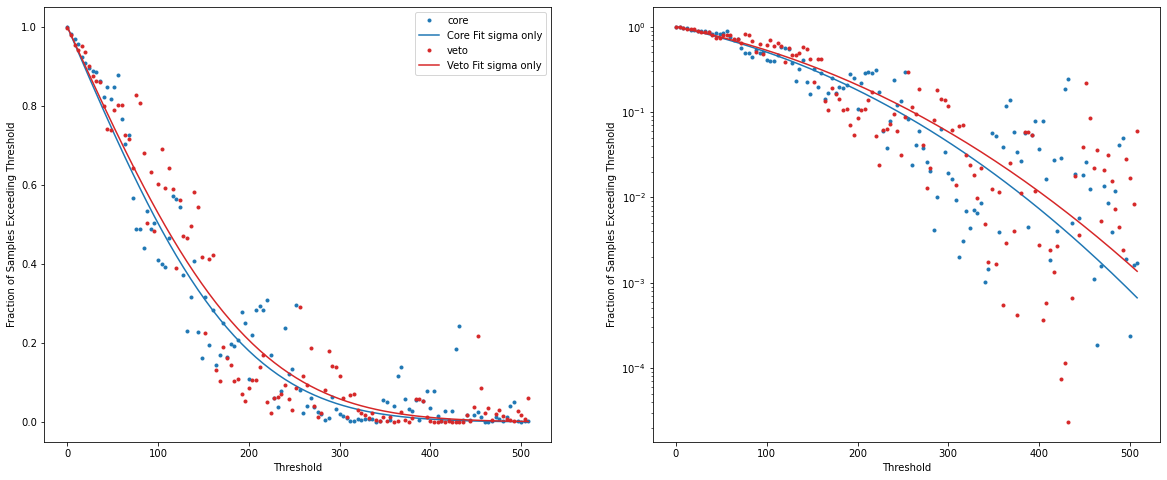

LWA-087A
Fit Core
[183.71860923]
[[24.96794059]]
Fit Veto
[189.27859057]
[[21.76184527]]


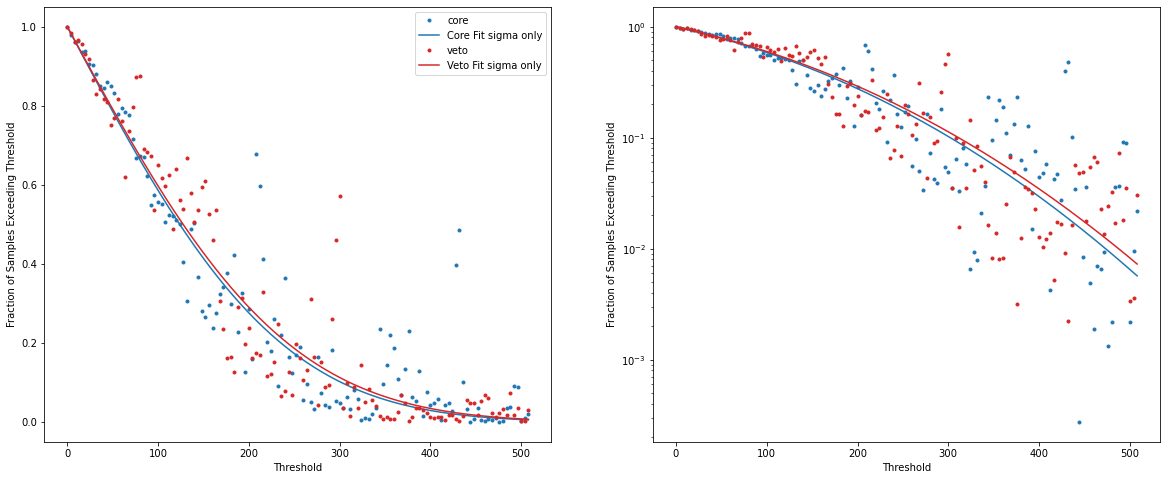

LWA-087B
Fit Core
[185.6915353]
[[20.00086661]]
Fit Veto
[190.67989947]
[[21.85964337]]


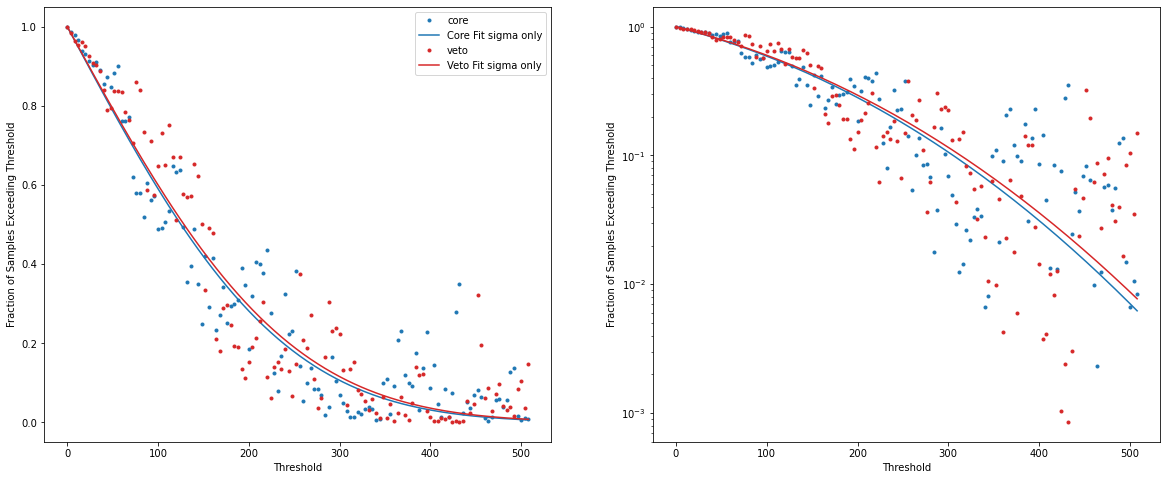

LWA-086A
Fit Core
[177.23512777]
[[24.07201636]]
Fit Veto
[183.04927813]
[[21.38015992]]


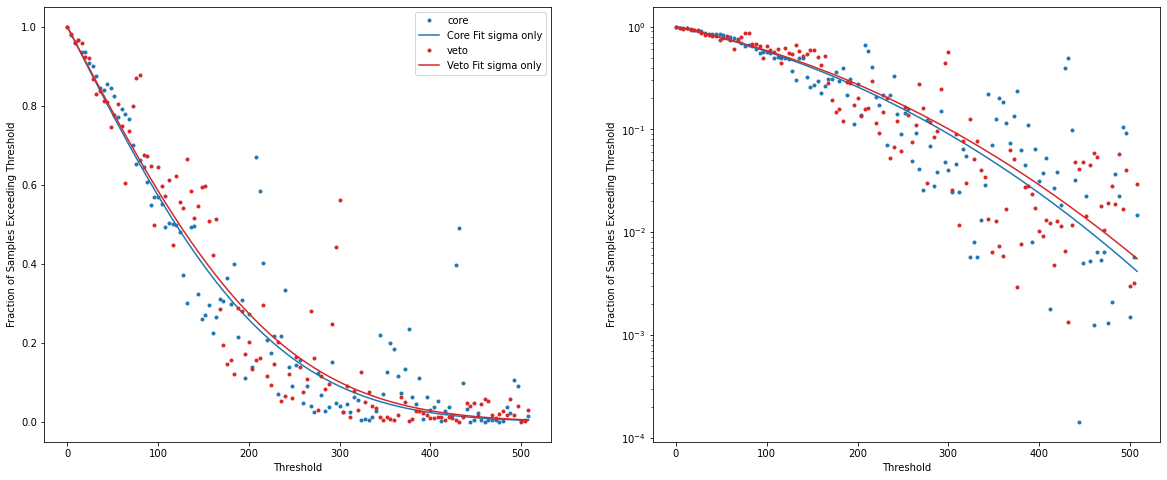

LWA-086B
Fit Core
[161.34019568]
[[10.94827565]]
Fit Veto
[169.01971037]
[[13.76723499]]


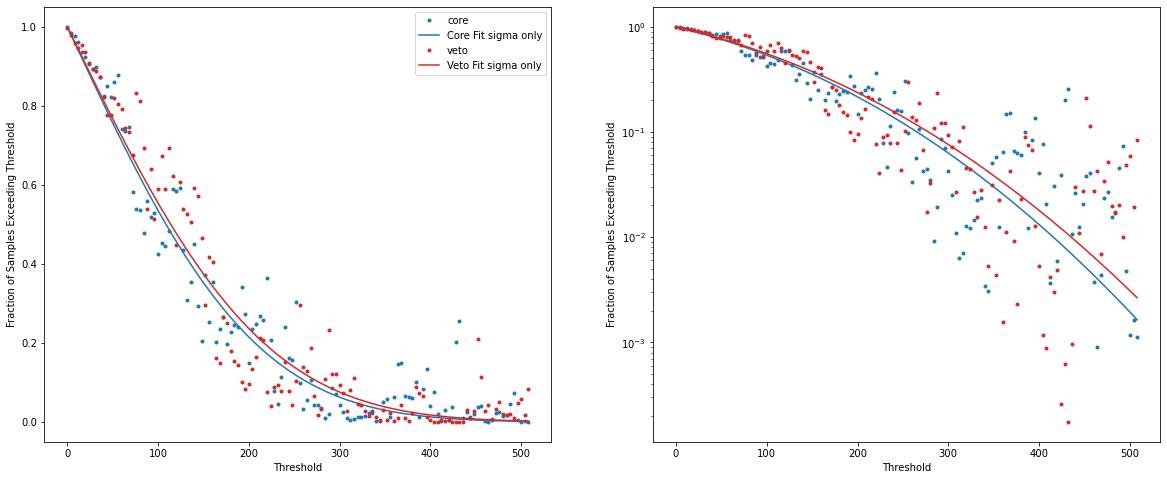

LWA-089A
Fit Core
[175.65888125]
[[26.70452166]]
Fit Veto
[183.47159649]
[[24.27156917]]


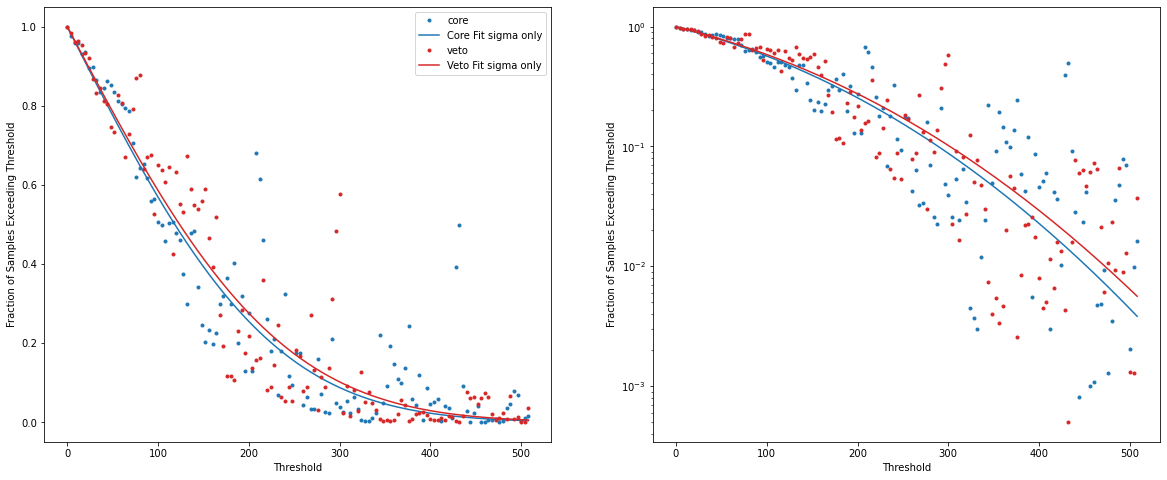

LWA-089B
Fit Core
[176.91279882]
[[18.06086055]]
Fit Veto
[181.5992124]
[[20.55669097]]


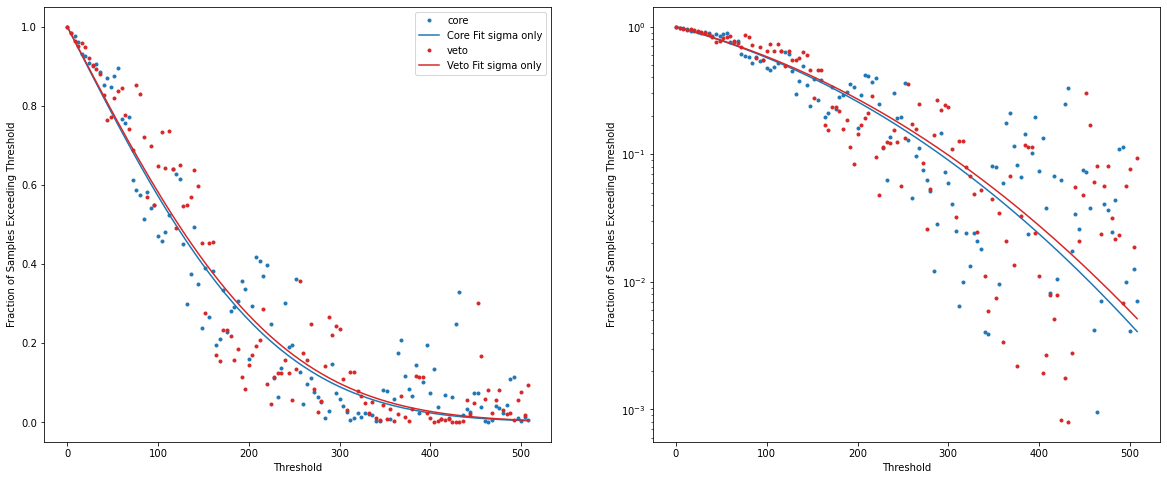

LWA-096A
Fit Core
[119.82919927]
[[6.64902288]]
Fit Veto
[130.64815388]
[[7.0962034]]


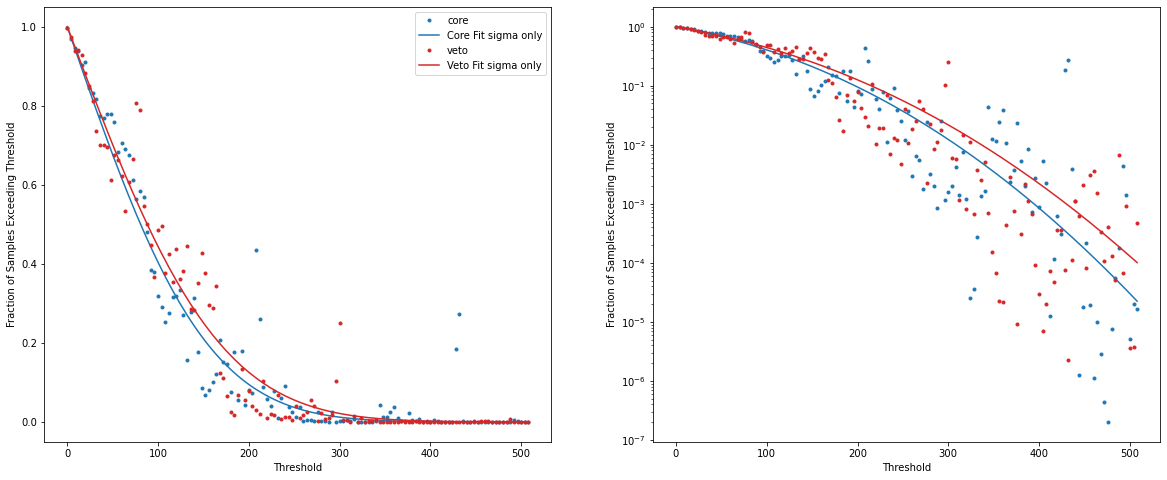

LWA-096B
Fit Core
[147.04397757]
[[10.7654732]]
Fit Veto
[157.45824708]
[[14.16255956]]


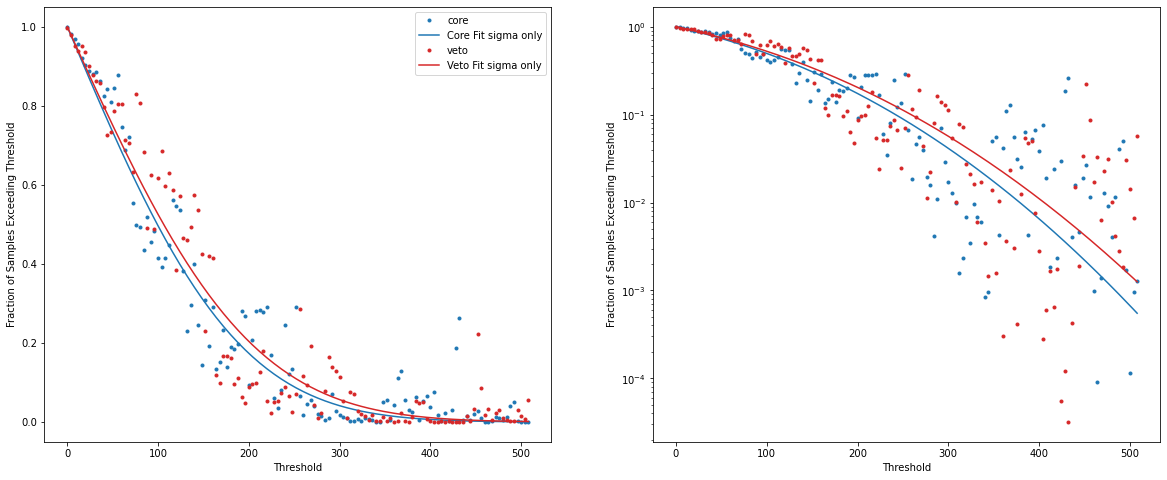

LWA-091A
Fit Core
[171.81357252]
[[25.33392636]]
Fit Veto
[179.25850283]
[[23.51286334]]


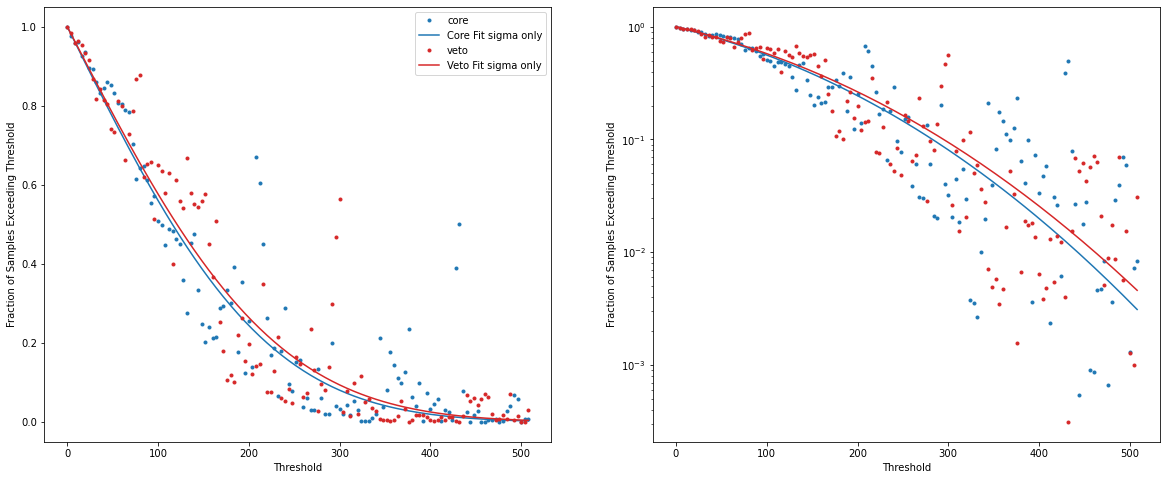

LWA-091B
Fit Core
[168.06455099]
[[14.59977903]]
Fit Veto
[174.76825294]
[[17.77300078]]


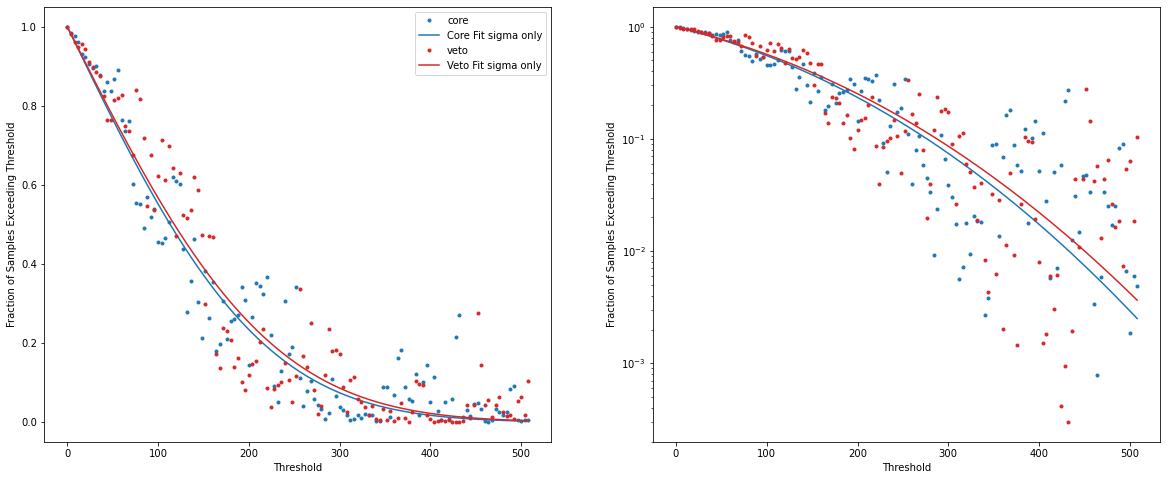

LWA-090A
Fit Core
[170.59124397]
[[24.39817558]]
Fit Veto
[177.97715457]
[[22.70367953]]


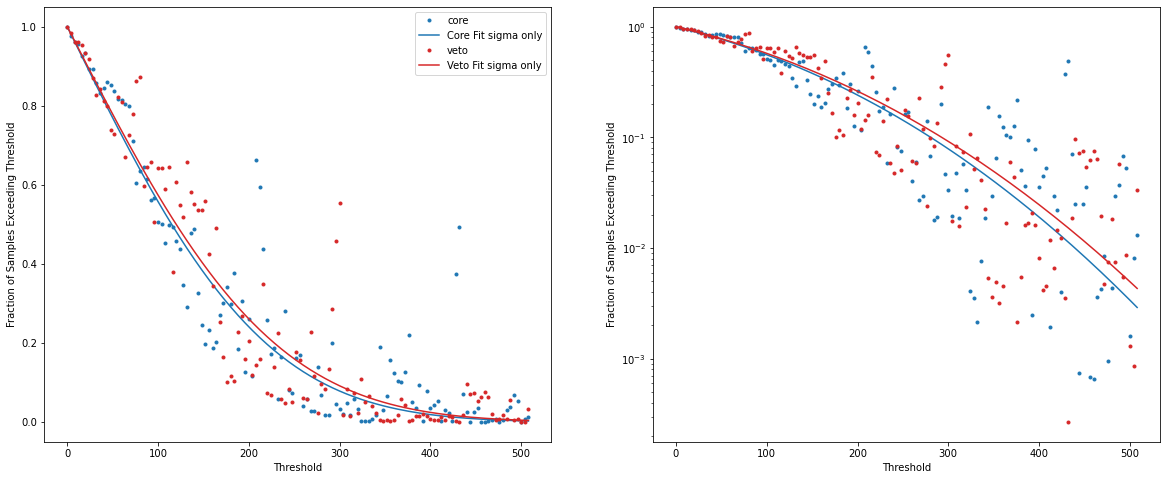

LWA-090B
Fit Core
[163.69097817]
[[13.52751705]]
Fit Veto
[170.65492181]
[[16.64092269]]


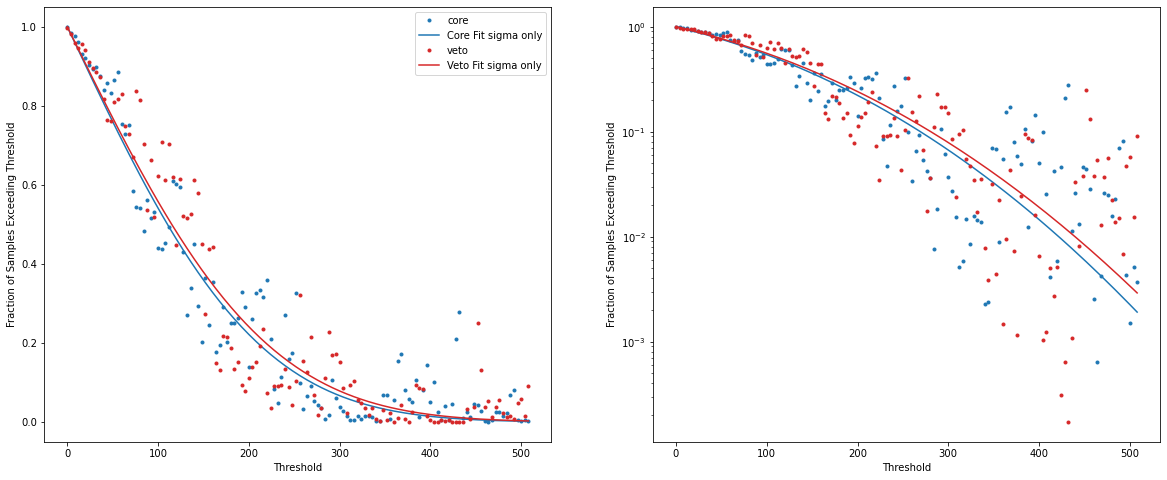

LWA-093A
Fit Core
[166.61872516]
[[22.21683249]]
Fit Veto
[173.43293322]
[[21.32602764]]


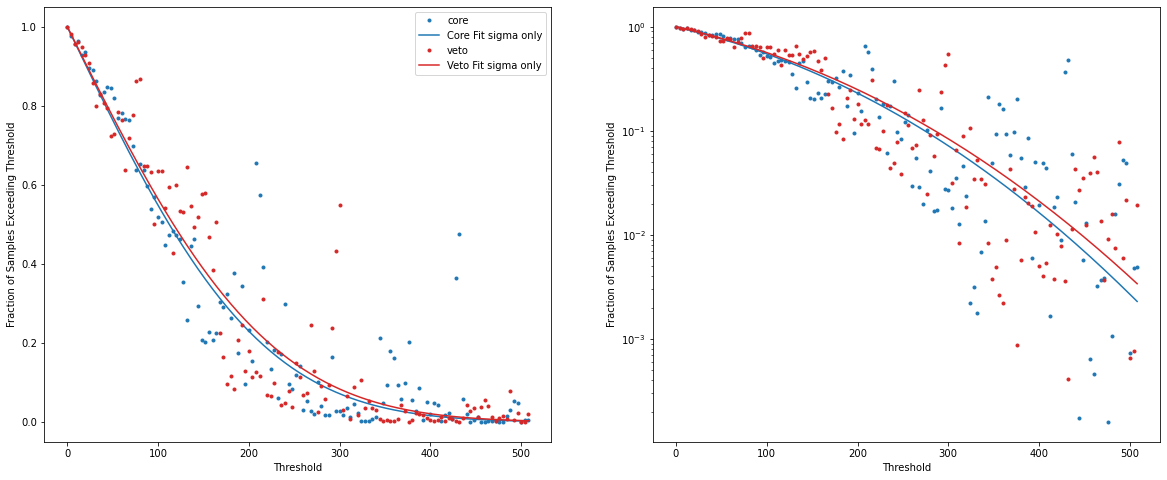

LWA-093B
Fit Core
[160.68860604]
[[11.77962764]]
Fit Veto
[167.87356195]
[[14.79952087]]


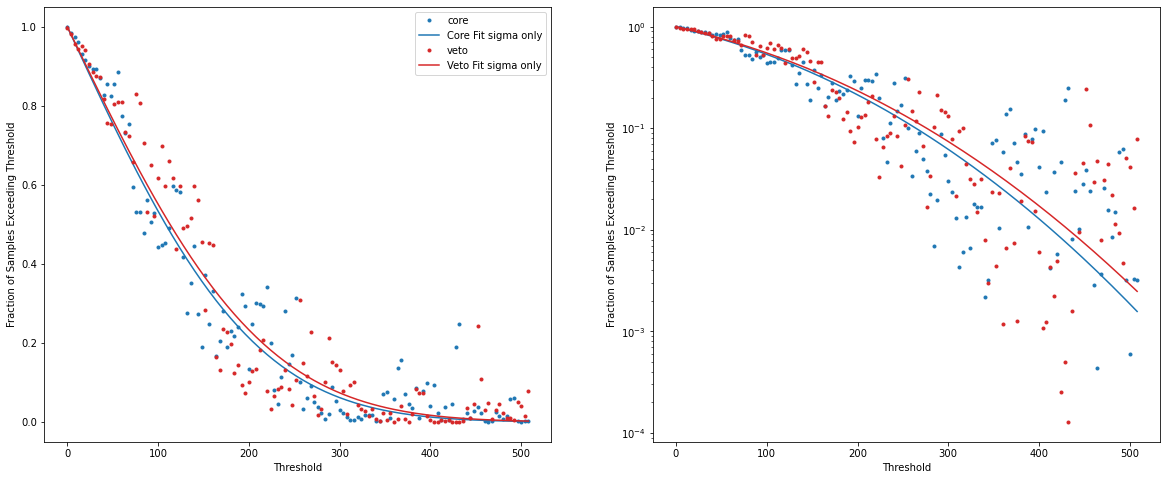

LWA-092A
Fit Core
[168.40264701]
[[22.442486]]
Fit Veto
[175.64453283]
[[21.58275476]]


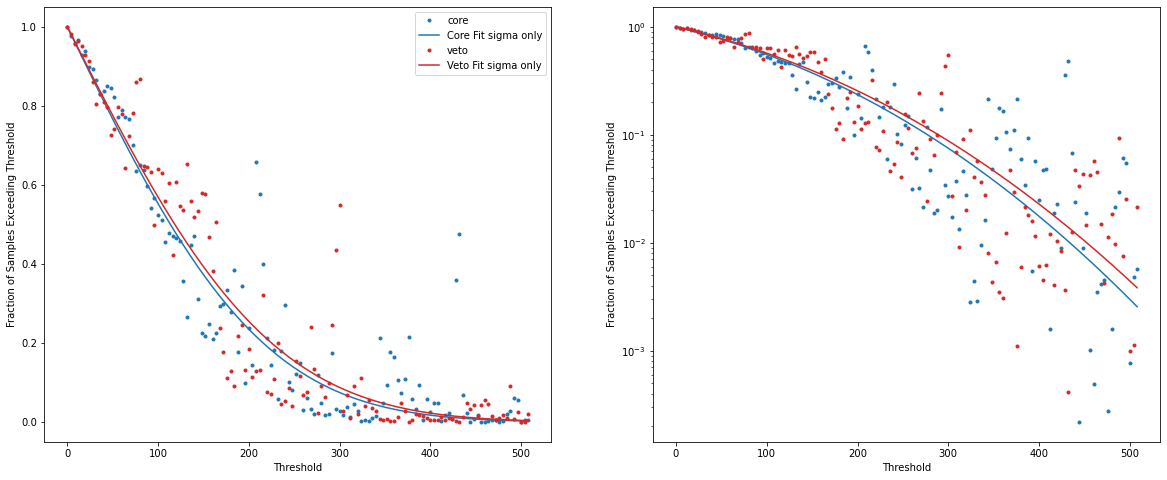

LWA-092B
Fit Core
[159.24980752]
[[12.13697514]]
Fit Veto
[166.34523377]
[[15.13576478]]


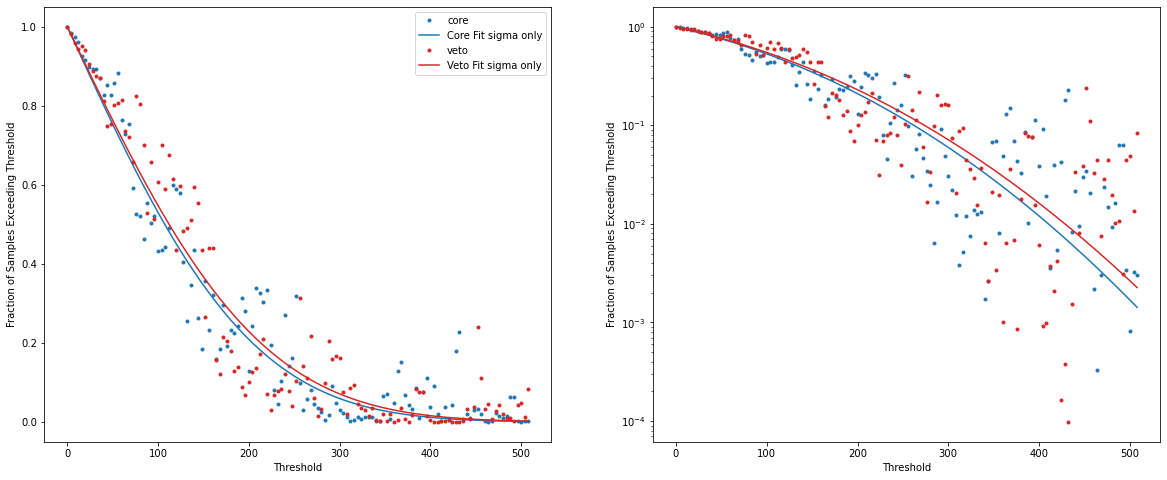

LWA-095A
Fit Core
[2.02229372]
[[0.01606226]]
Fit Veto
[2.32256818]
[[0.01048537]]


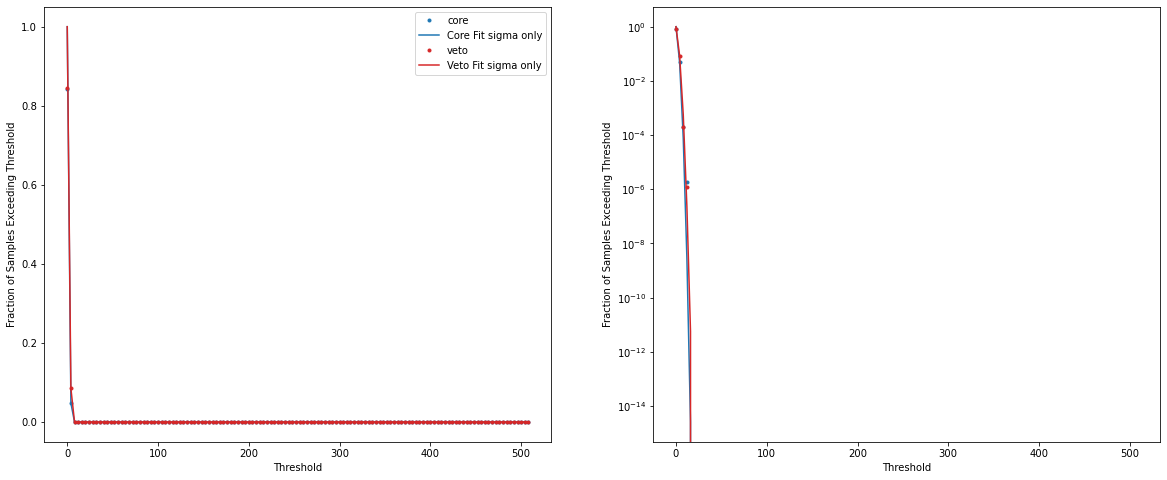

LWA-095B
Fit Core
[151.24597099]
[[12.57717446]]
Fit Veto
[162.34119652]
[[15.82934185]]


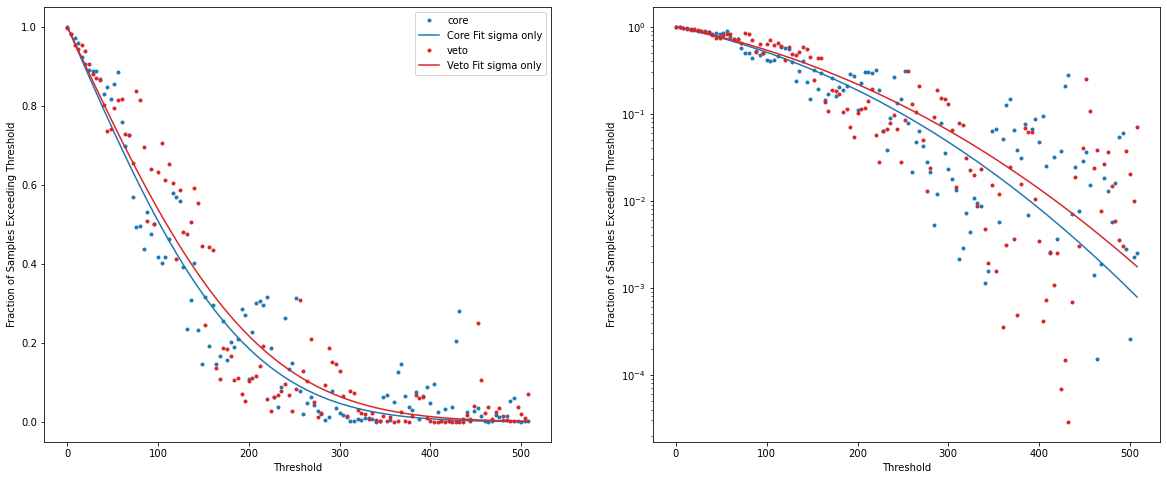

LWA-094A
Fit Core
[170.9937536]
[[24.51375966]]
Fit Veto
[177.89760179]
[[23.14980049]]


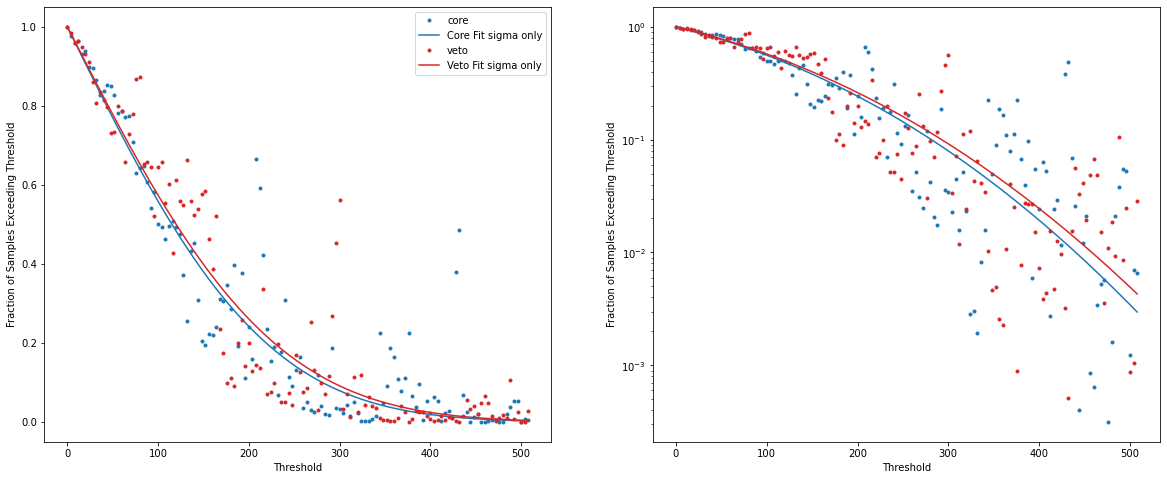

LWA-094B
Fit Core
[152.41436576]
[[11.4533788]]
Fit Veto
[160.85708116]
[[14.74964359]]


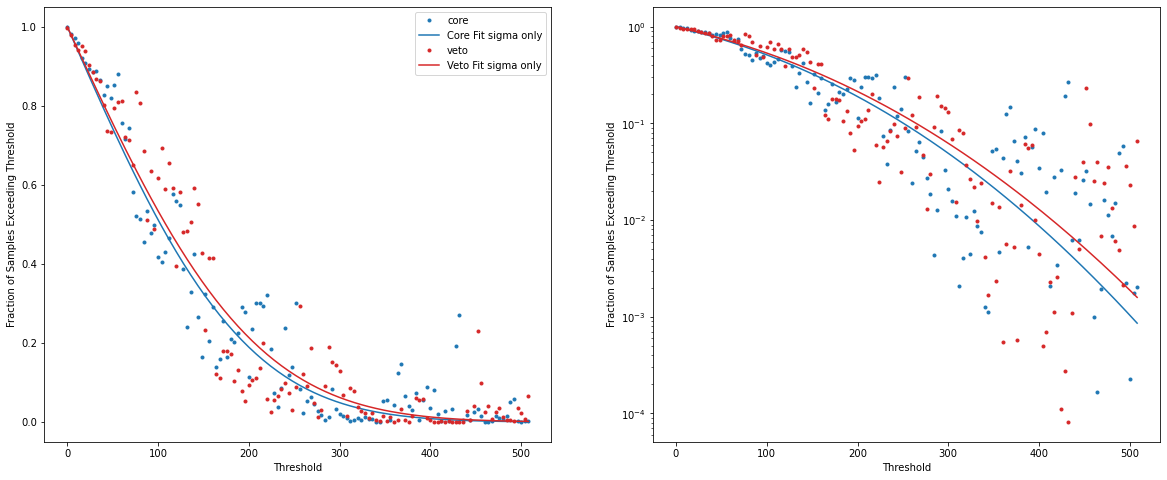

LWA-122A
Fit Core
[174.05361633]
[[23.50301553]]
Fit Veto
[181.30890394]
[[21.31889046]]


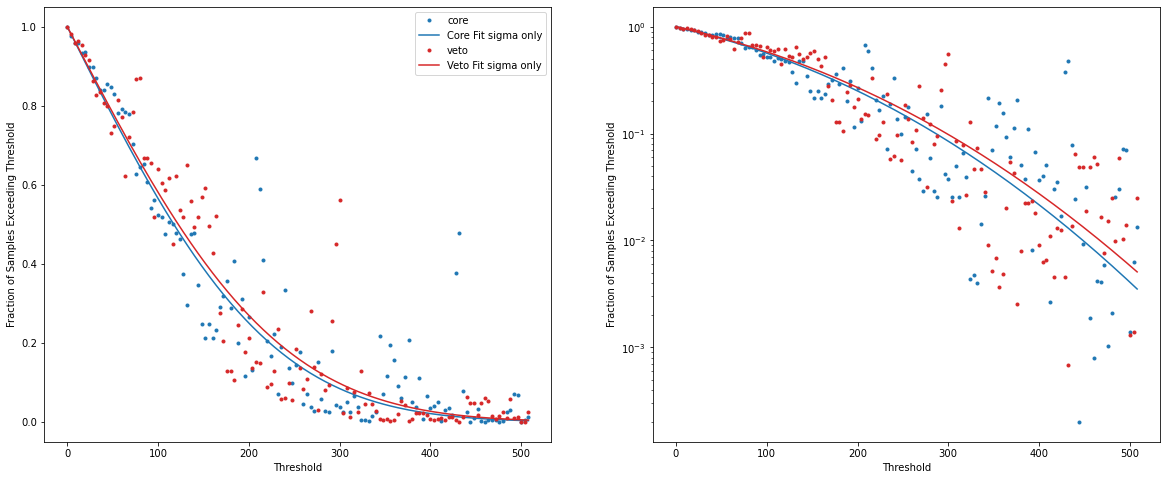

LWA-122B
Fit Core
[181.86266583]
[[19.86472027]]
Fit Veto
[187.0097617]
[[22.26243876]]


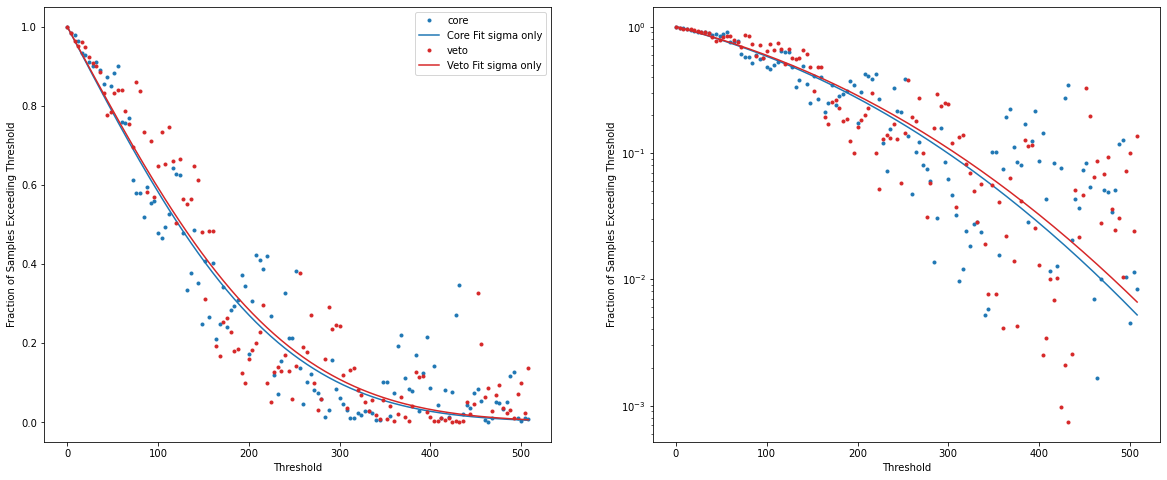

LWA-121A
Fit Core
[177.28854874]
[[24.91797509]]
Fit Veto
[184.54365846]
[[21.95273931]]


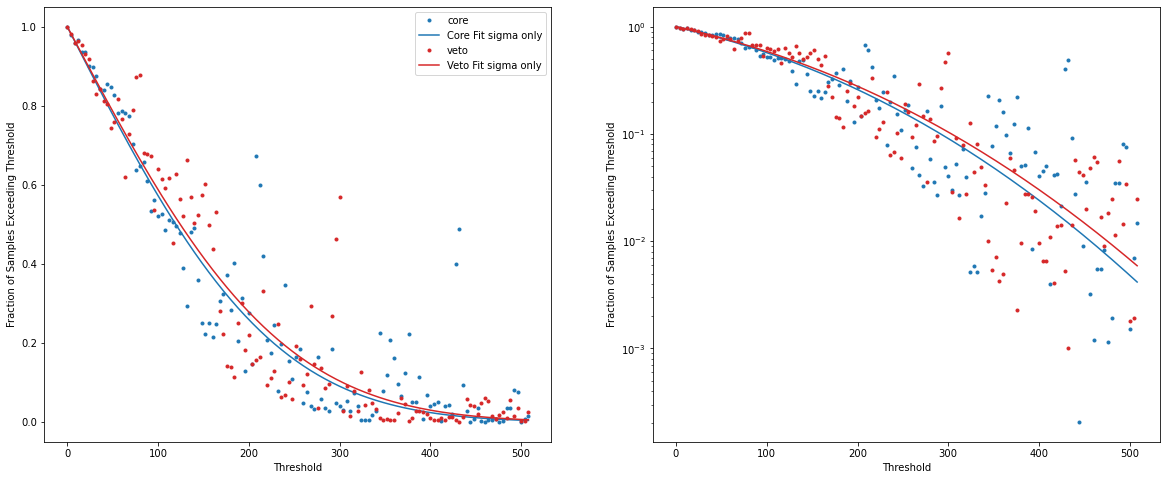

LWA-121B
Fit Core
[169.44697232]
[[16.58073473]]
Fit Veto
[178.00917286]
[[19.12956524]]


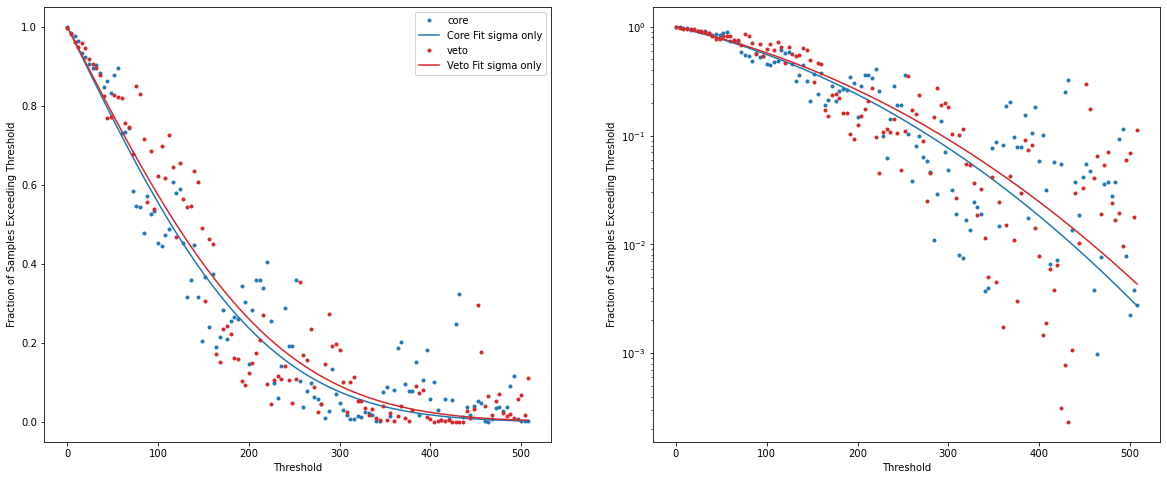

LWA-325A
Fit Core
[134.7719091]
[[4.1348612]]
Fit Veto
[129.58184943]
[[3.61916109]]


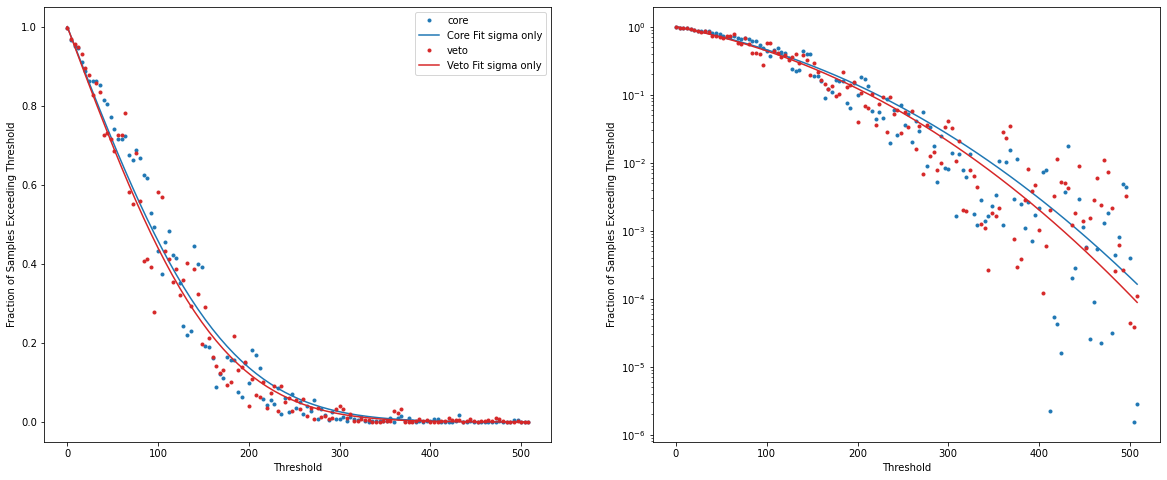

LWA-325B
Fit Core
[15.41027642]
[[0.02388511]]
Fit Veto
[13.1123962]
[[0.01185295]]


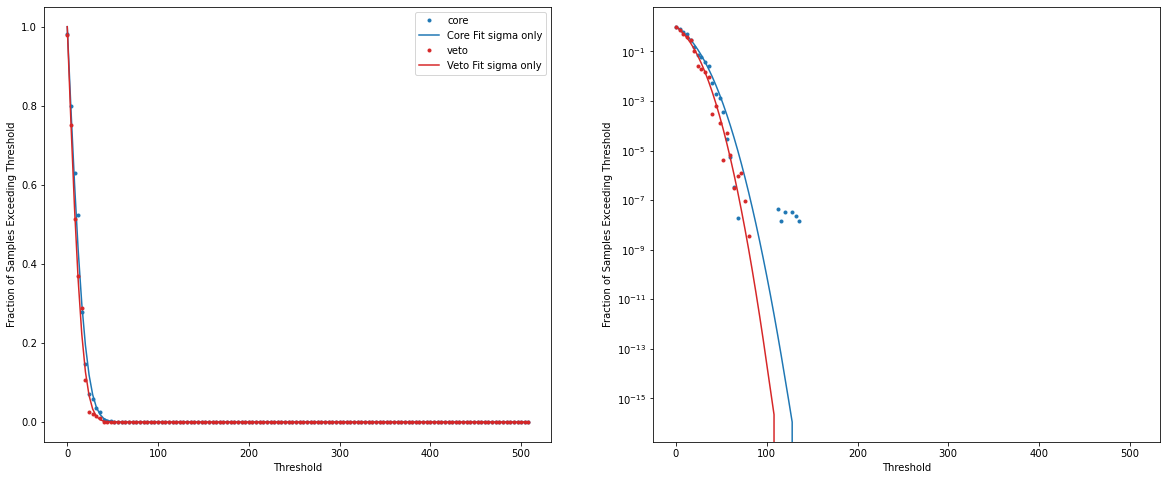

LWA-316A
Fit Core
[155.12363257]
[[22.58382905]]
Fit Veto
[170.00851635]
[[19.49233568]]


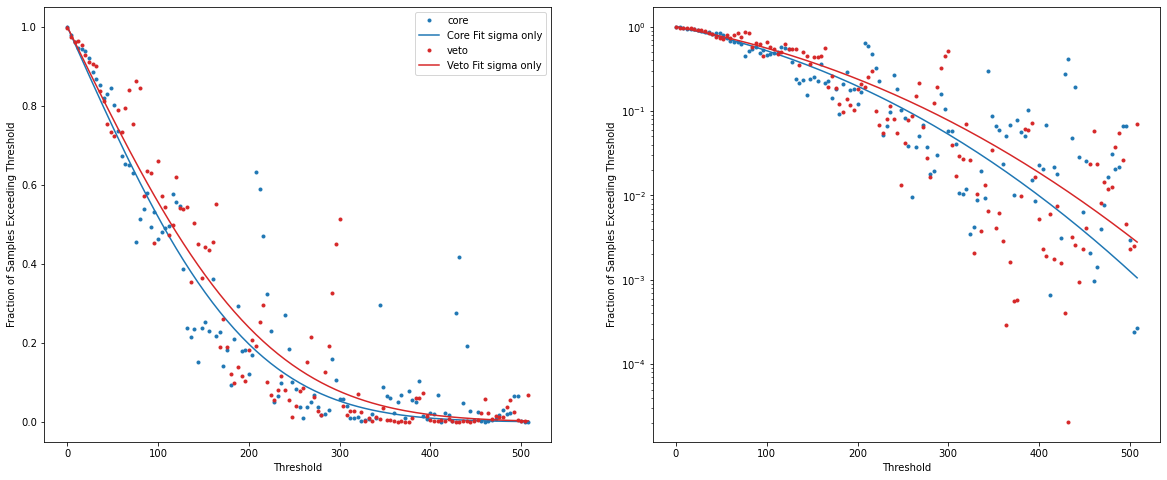

LWA-316B
Fit Core
[193.44635382]
[[27.46664394]]
Fit Veto
[199.0466215]
[[30.01753572]]


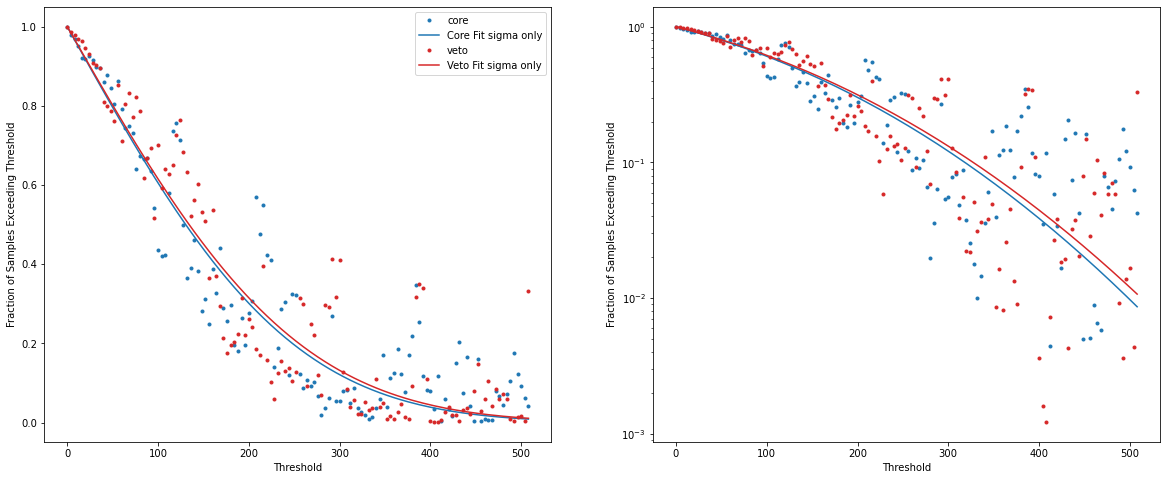

LWA-334A
Fit Core
[3.62440339]
[[0.00395251]]
Fit Veto
[3.64975902]
[[0.00422301]]


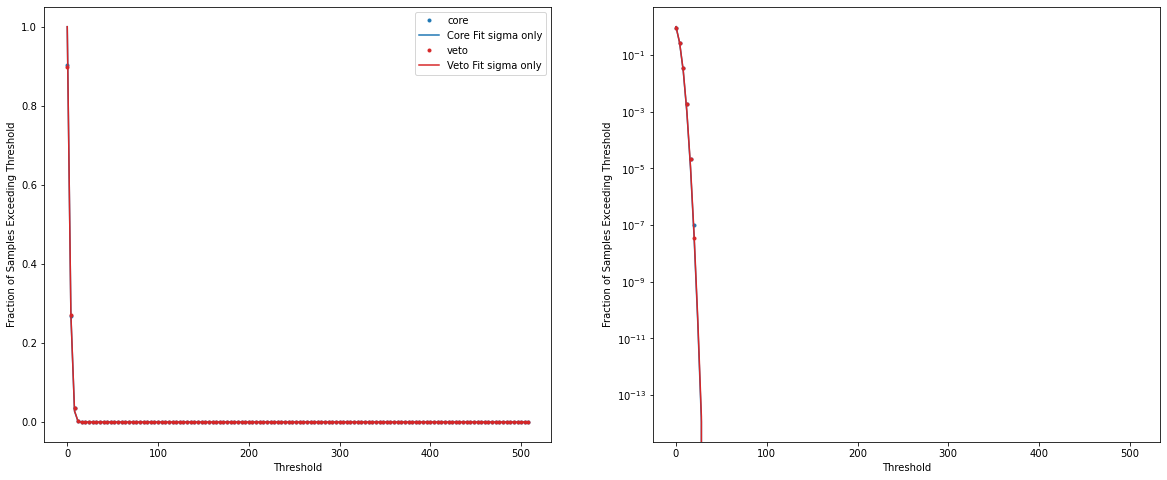

LWA-334B
Fit Core
[3.08216417]
[[0.0045881]]
Fit Veto
[3.06481871]
[[0.00465958]]


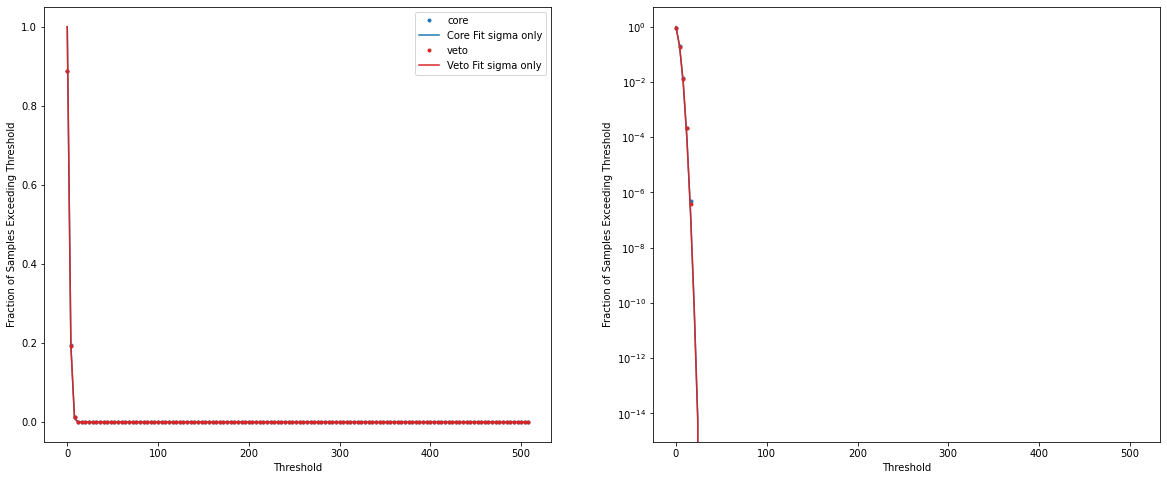

LWA-328A
Fit Core
[157.4837681]
[[16.99350841]]
Fit Veto
[169.39650589]
[[20.55195871]]


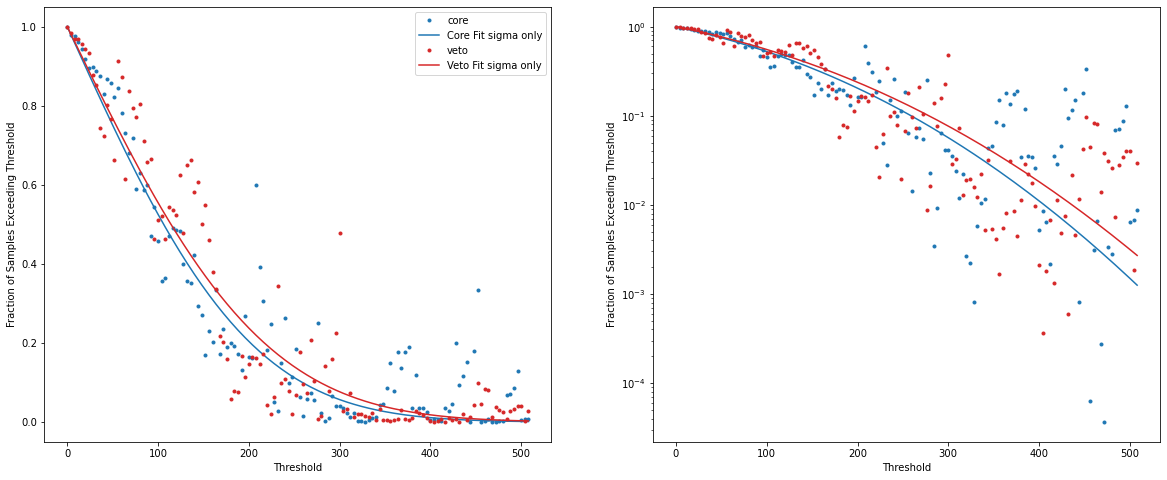

LWA-328B
Fit Core
[134.99877751]
[[7.38111253]]
Fit Veto
[137.83342104]
[[8.52953181]]


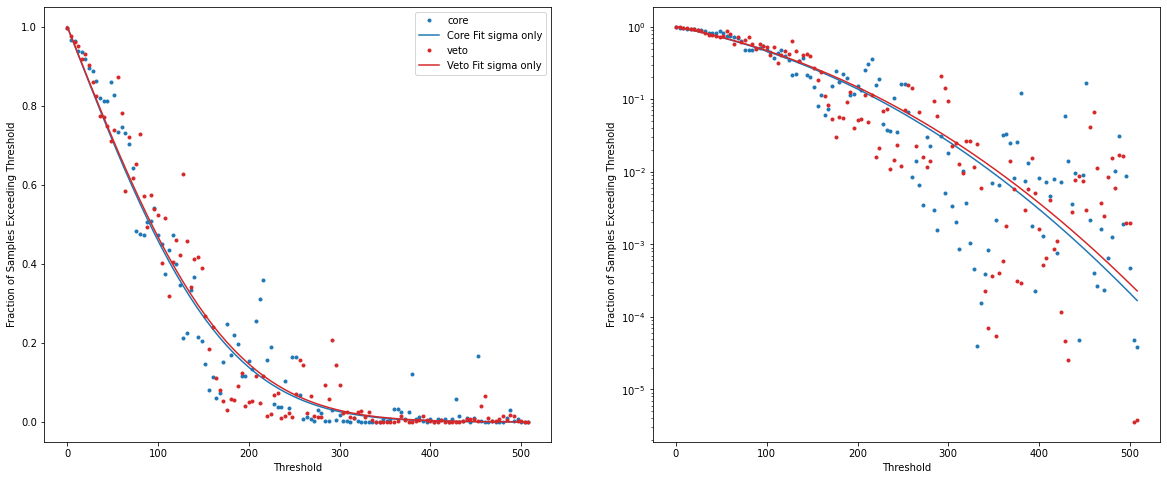

LWA-361A
Fit Core
[3.10100824]
[[0.0026039]]
Fit Veto
[3.07040774]
[[0.00272245]]


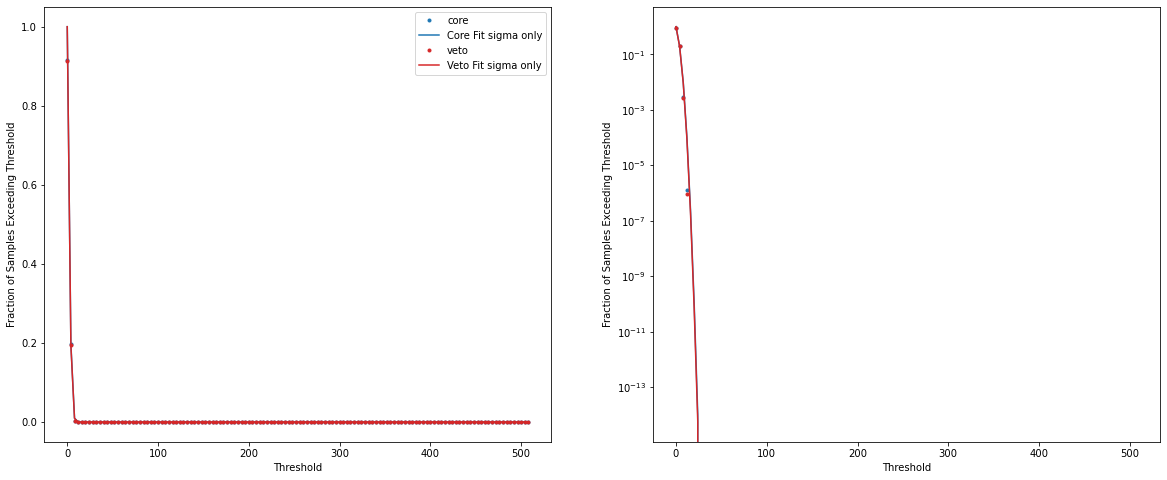

LWA-361B
Fit Core
[2.50719485]
[[0.00752232]]
Fit Veto
[2.50037698]
[[0.00764854]]


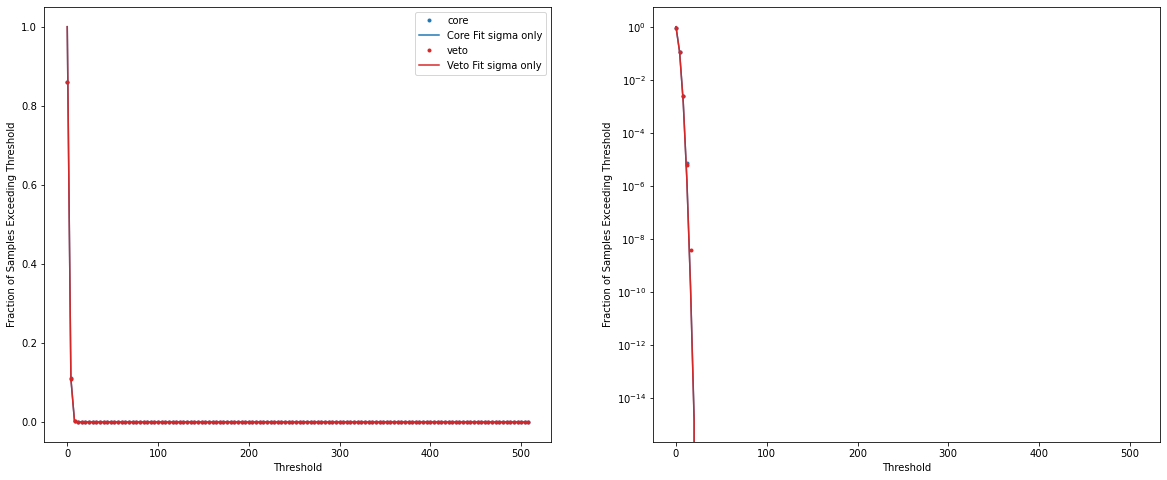

LWA-358A
Fit Core
[2.56904215]
[[0.00743713]]
Fit Veto
[2.55378245]
[[0.00755073]]


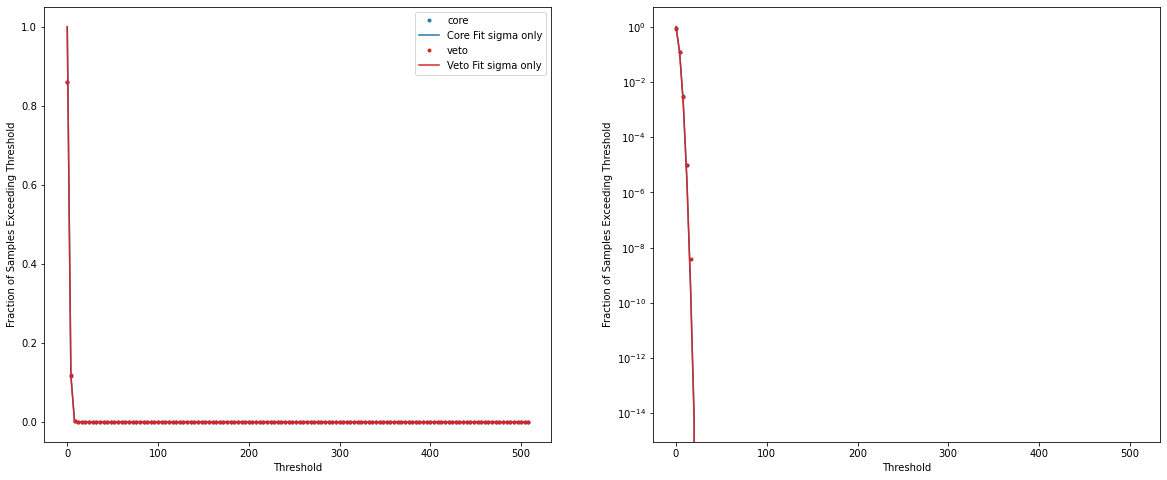

LWA-358B
Fit Core
[3.61542557]
[[0.00334455]]
Fit Veto
[3.50833867]
[[0.00415146]]


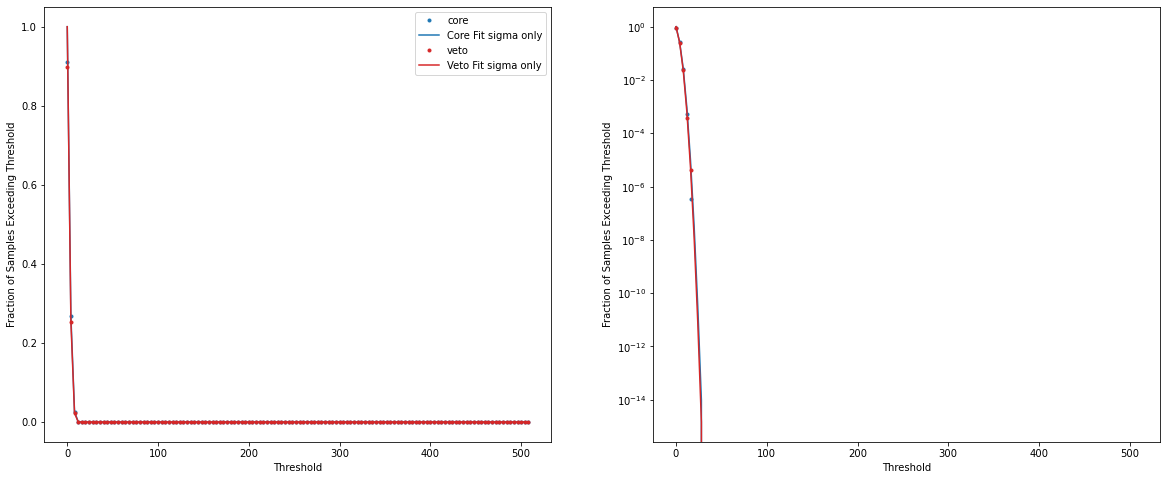

In [272]:
def prob_simple(x,s):
    #fraction of samples whose absolute value iexceeds a threshold x if the sample is described by a Gaussian PDF with zero mean and variance s^2
    p = 1 - 0.5*(sp.erf((x)/((2**0.5)*s)) + sp.erf((x)/((2**0.5)*s)))
    return p

results_core=np.load('/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/tests2023Jan5/individual_antenna_thresh_scan_brd9_c.npy')
results_veto=np.load('/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/tests2023Jan5/individual_antenna_thresh_scan_brd9_v.npy')


results_core=np.load('/home/ubuntu/kp/data/2023Jan14/snap051673764473.2053006results_c.npy')
results_veto=np.load('/home/ubuntu/kp/data/2023Jan14/snap051673764473.2053006results_v.npy')

results_core=np.load('/home/ubuntu/kp/data/2023Jan14/snap051673808916.1242733results_c.npy')
results_veto=np.load('/home/ubuntu/kp/data/2023Jan14/snap051673808916.1242733results_v.npy')

#snap051673764473.2053006results_c.npy

rate_core = results_core/(2**28 - 1)
rate_veto = results_veto/(2**28 - 1)

corefitsigmas = np.zeros(64)
corefitsigmaerrs = np.zeros(64)
vetofitsigmas = np.zeros(64)
vetofitsigmaerrs = np.zeros(64)

for a in range(64):
    antname=mapping.snap2_to_antpol(boardnumber,a)
    print(antname)
    print("Fit Core")
    popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[a,:])
    corefitsigmas[a]=popt1[0]
    corefitsigmaerrs[a]=pcov1[0]
    print(popt1)
    print(pcov1)

    print("Fit Veto")
    popt2,pcov2 = oz.curve_fit(prob_simple,thresholds,np.flip(rate_veto[a,:]))
    vetofitsigmas[a]=popt2[0]
    vetofitsigmaerrs[a]=pcov2[0]
    print(popt2)
    print(pcov2)

    model1 = prob_simple(thresholds,popt1[0])
    model2 = prob_simple(thresholds,popt2[0])

    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.xlabel("Threshold")
    plt.ylabel("Fraction of Samples Exceeding Threshold")
    plt.plot(thresholds,rate_core[a,:],'C0.',label='core')
    plt.plot(thresholds,model1,'C0-',label="Core Fit sigma only")

    plt.plot(np.flip(thresholds),rate_veto[a,:],'C3.',label='veto')
    plt.plot(thresholds,model2,'C3-',label="Veto Fit sigma only")

    plt.legend()

    plt.subplot(122)
    plt.xlabel("Threshold")
    plt.ylabel("Fraction of Samples Exceeding Threshold")
    plt.semilogy(thresholds,rate_core[a,:],'C0.',label='core')
    plt.semilogy(thresholds,model1,'C0-',label="Core Fit sigma only")

    plt.semilogy(np.flip(thresholds),rate_veto[a,:],'C3.',label='veto')
    plt.semilogy(thresholds,model2,'C3-',label="Veto Fit sigma only")
    plt.show()

Is there a factor of two wrong in the model fit?

In [207]:
colors = ["#934b71","#48c152","#9a44bc","#78c341","#4a62d8","#abc136","#a076e9","#6b9c29","#dd70db","#389139","#c63695","#39c685","#d93668","#81be6d","#7854b1","#d0b737","#578cea","#e7a332","#5d63b4","#e58323","#3a69af","#dd6128","#54b9e5","#be2e2c","#46c6c4","#ea5749","#329981","#ea6098","#428f5c","#a24e99","#a6a83d","#c58fdb","#767c16","#e381be","#587b28","#9c9cde","#987516","#5092c9","#bd7426","#5a5f94","#c69d3f","#88609d","#357137","#b14a78","#6ebf92","#a4384a","#277257","#d56470","#78964f","#e08ea5","#586113","#e88c79","#56642b","#cd6a49","#b7b771","#96515d","#908645","#a04616","#dda573","#a45141","#755a1c","#ec945a","#89562c","#ad7947"]

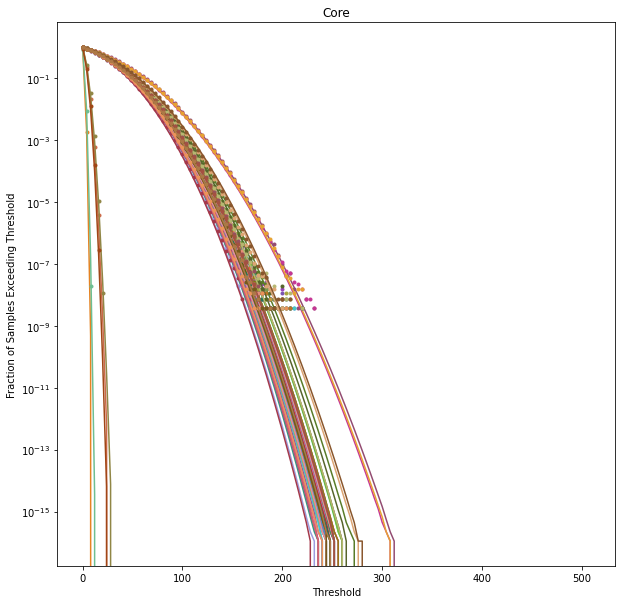

In [208]:
plt.figure(figsize=(10,10))
plt.title("Core")
for a in range(64):
    model1 = prob_simple(thresholds,corefitsigmas[a])
    plt.semilogy(thresholds,model1,color=colors[a],label="Core Fit sigma only")
    plt.semilogy(thresholds,rate_core[a,:],'.',color=colors[a],label=str(a))

plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
#plt.legend()
plt.show()


# How often are antennas saturating?

508
0
0
0


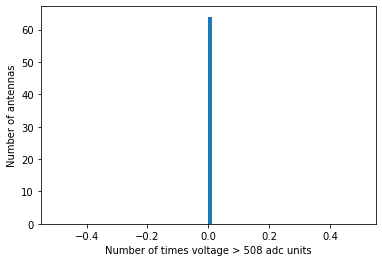

In [209]:
# how often is saturation?
plt.figure()
plt.hist(results_core[:,-1],80)
plt.xlabel("Number of times voltage > 508 adc units")
plt.ylabel("Number of antennas")

print(thresholds[-1])
count=0
for a in range(64):
    if results_core[a,-1]>1000:
        antname=mapping.snap2_to_antpol(boardnumber,a)
        print('antennas that saturated more than 1000 times',antname, results_core[a,-1])
        count+=1
print(count)

count=0
for a in range(64):
    if results_core[a,-1]>100:
        antname=mapping.snap2_to_antpol(boardnumber,a)
        #print('antennas that saturated more than 100 times',antname, results_core[a,-1])
        count+=1
print(count)

count=0
for a in range(64):
    if results_core[a,-1]>=1:
        antname=mapping.snap2_to_antpol(boardnumber,a)
        #print('antennas that saturated',antname, results_core[a,-1])
        count+=1
    
print(count)



# Single Board Threshold Scan, no veto
For this test, all the antennas are trigger antennas.

In [210]:
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',0)


In [211]:
core_roles_array=np.ones(64,dtype=int)
core_roles1,core_roles2=packantennaroles(core_roles_array)
print(core_roles1,core_roles2)
#set the antenna roles
setvalue(casperbrd,'trigger_antennas1','cr_registers.xlsx',core_roles1)
setvalue(casperbrd,'trigger_antennas2','cr_registers.xlsx',core_roles2)
setvalue(casperbrd,'veto_antennas1','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_antennas2','cr_registers.xlsx',0)
setvalue(casperbrd,'trigger_window','cr_registers.xlsx',int(round(1.97e8*100/3e8,1))) #number of clock cycles to travel 100 meters
setvalue(casperbrd,'veto_window','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',5) 
setvalue(casperbrd,'veto_number_thresh','cr_registers.xlsx',0) #not using for now



4294967295 4294967295


In [213]:
voltage_thresh=np.asarray([50,100,150,200,225,250,270,300,350,400,450,500,512])
ant_number_thresh=np.asarray([4,5,6,7])
core_coincidences=np.zeros((len(voltage_thresh),len(ant_number_thresh)))
for m in range(len(ant_number_thresh)):
    setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',ant_number_thresh[m]) 
    for i in range(len(voltage_thresh)):
        t_c = voltage_thresh[i]
        setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2))
        time.sleep(2.75)  #have to wait for it to update
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        core_coincidences[i,m]=core_coincidence

Text(0, 0.5, 'number of coincidences')

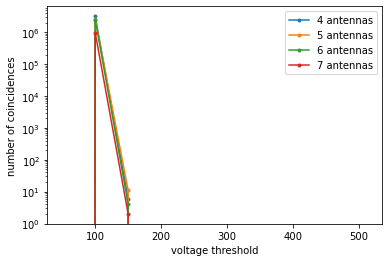

In [216]:
for m in range(len(ant_number_thresh)):
    plt.semilogy(voltage_thresh,core_coincidences[:,m],'.-',label=str(ant_number_thresh[m])+ ' antennas')
plt.legend()
plt.xlabel('voltage threshold')
plt.ylabel('number of coincidences')

This is a plot of the number of events meeting the coincident trigger condition, for different voltage thresholds and antenna number thresholds. Note that no veto antennas were set and each measurement is done sequentially, in a dynamic RFI environment.

## Capture internally-triggered snapshots, core only

In [250]:

threshold=125
core_roles_array=np.ones(64,dtype=int)
core_roles1,core_roles2=packantennaroles(core_roles_array)
#set the antenna roles
setvalue(casperbrd,'trigger_antennas1','cr_registers.xlsx',core_roles1)
setvalue(casperbrd,'trigger_antennas2','cr_registers.xlsx',core_roles2)
setvalue(casperbrd,'veto_antennas1','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_antennas2','cr_registers.xlsx',0)
#set the other trigger veto parameters
setvalue(casperbrd,'trigger_window','cr_registers.xlsx',int(round(1.97e8*100/3e8,1))) #number of clock cycles to travel 100 meters
setvalue(casperbrd,'veto_window','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',4) 
setvalue(casperbrd,'veto_number_thresh','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(threshold**2))


In [251]:
#prepare ethernet
setup_data_source(casperbrd,"adc")
setup_ethernet(brdname,casperbrd,fpgfile,'lwacr',100)
setvalue(casperbrd,'brd_id','cr_registers.xlsx',11)  #this is wrong, should be board 9 but doesnt work anyway
#enable ethernet
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)


Data source set to adc
------------------------
snap05:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:05:05:05
Gateway:  0.0.0.1
IP:  10.41.0.205
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 58: MAC: 04:3F:72:DF:C2:F8
Setting wait between packets to 100


In [252]:

#enable coincidence trigger for a short time
setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)
time.sleep(2)
setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0)

### Analyze results

In [254]:
8768/64

137.0

In [255]:

def ploteventtimeseries_singlesnap(fname,threshold,zoom,boardnumber):
    #plots the timeseries for each antenna in a single snap2 
    #Antennas that exceeded the threshold at any time in the windo are highlighted in purple 
    #The time series is zoomed around the peak (which is not necessarily the peak that triggered the readout)
    #fname is the file name of the single board snapshot
    #threshold is the voltage threshold
    #zoom is the number of clock cycles to show before and after the peak. If zoom=0, no zooming is done
    #board number is the fpga number to use to look up the antenna names
    chanmap=np.loadtxt('channelmap.txt')
    snapshot=np.load(fname)
    fig = plt.figure(figsize=(20,15))
    count=0
    for i in range(64):
            timeseries=snapshot[:,i+4]
            fpgachan=chanmap[1,i]
            antname=mapping.snap2_to_antpol(boardnumber,fpgachan)
            #determine whether this antenna was ever above threshold
            c='black'
            peaksq=max(np.square(timeseries))
            if max(np.square(timeseries))>threshold**2:
                #print(antname,math.sqrt(peaksq))
                count+=1
                c='purple'
            ax=fig.add_subplot(8,8,1+i)
            plt.plot(timeseries)
            ax.text(.5,.5,antname,horizontalalignment='center',transform=ax.transAxes,color=c)
            if i > 55:
                plt.xlabel('time sample')
            if i%8==0:
                plt.ylabel('voltage [ADC units]')
            if zoom!=0:
                plt.xlim(np.argmax(timeseries)-zoom,np.argmax(timeseries)+zoom)
    print('Number of antennas exceeding threshold: ', count)
    return

def count_antennas_over_threshold_singlesnap(fname,threshold):
    #counts how many antennas in the single-board-snapshot exceed (in absolute value) the given threshold
    count=0
    snapshot=np.load(fname)
    for i in range(64):
            fpgachan=chanmap[1,i]
            timeseries=snapshot[:,i+4]
            peaksq=max(np.square(timeseries))
            if max(np.square(timeseries))>threshold**2:
                count+=1
    return count

def count_directory(directory,threshold):
    #counts how many antennas exceeded the threshold for each snapshot in the given directory
    #the directory must contain single-board snapshots and nothing else
    snapshotlist=os.listdir(directory)
    counts=np.zeros(len(snapshotlist))
    for i,s in enumerate(snapshotlist):
        fname=directory+s
        counts[i]=count_antennas_over_threshold_singlesnap(fname,threshold)
    return counts


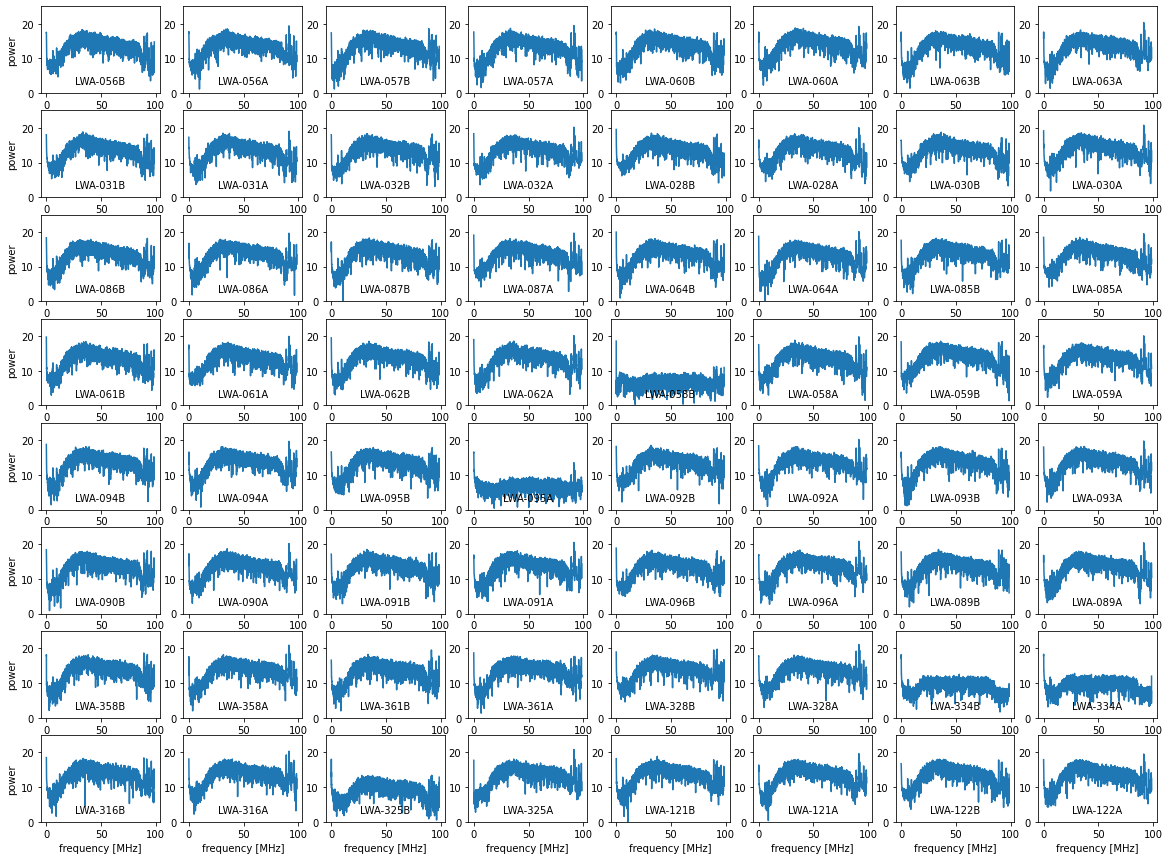

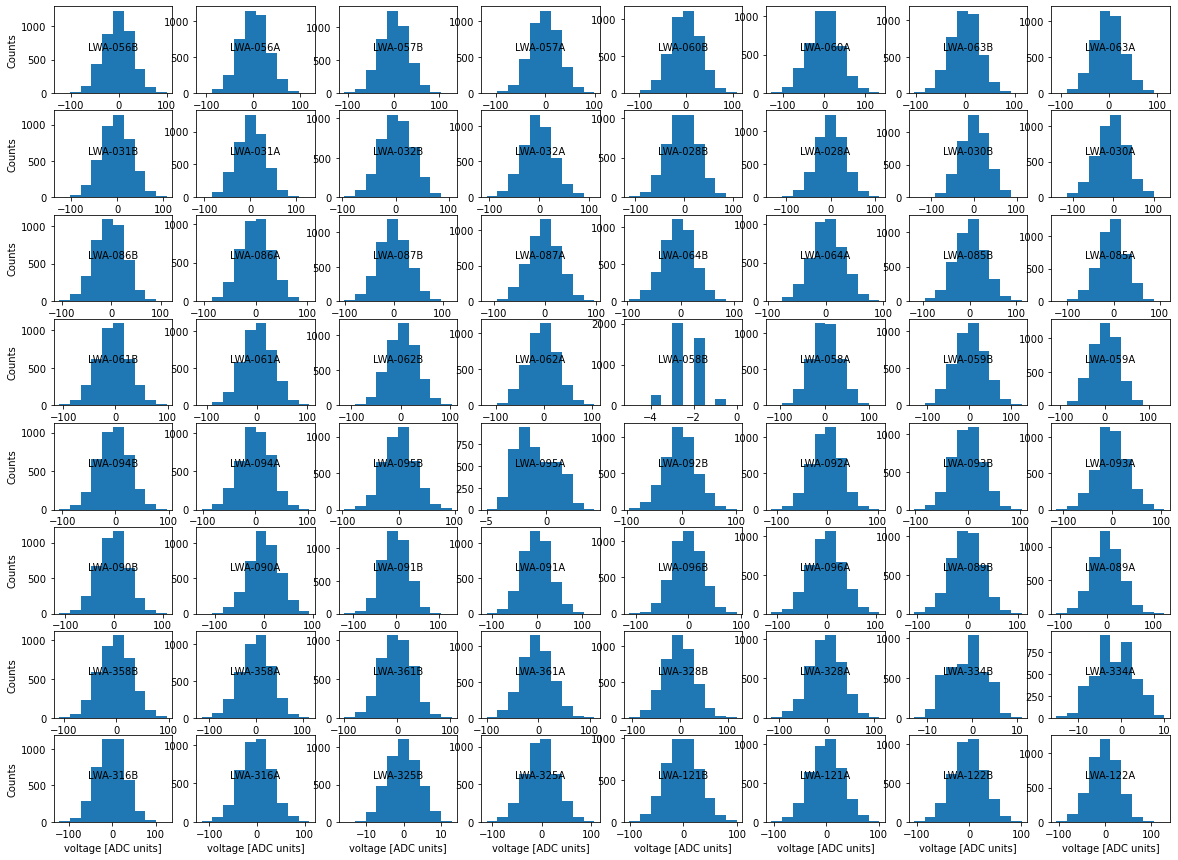

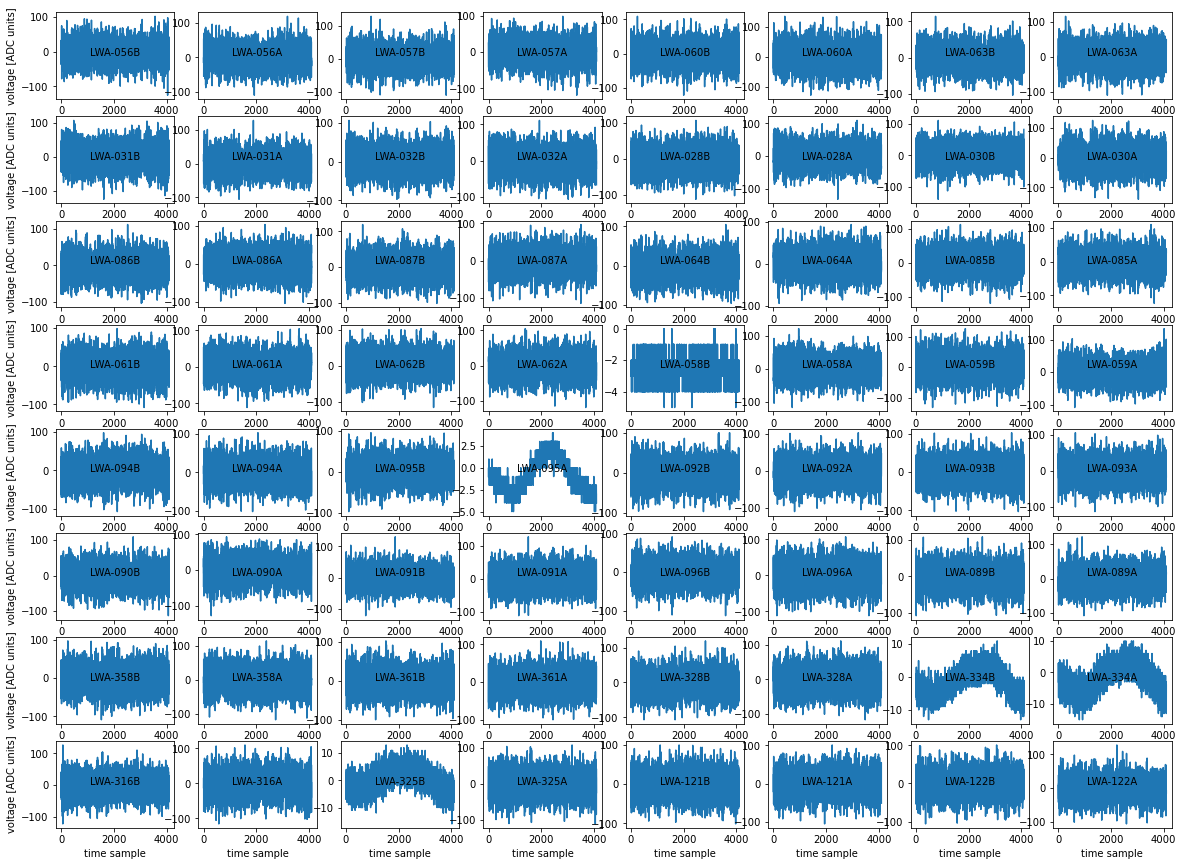

In [257]:
test1_snapshots=['single_board_snapshot1673760961.9958773_0_1.npy']
prefix= '/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/tests2023Jan14/'

for s in test1_snapshots:
    single_board_snapshot_summary_plots(prefix+s,boardnumber)


In [258]:
'''prefix= '/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/testing2023Jan3/second_test/'
test2_snapshots=os.listdir(prefix)

for s in test2_snapshots:
    print(s)
    single_board_snapshot_summary_plots(prefix+s,boardnumber)'''

"prefix= '/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/testing2023Jan3/second_test/'\ntest2_snapshots=os.listdir(prefix)\n\nfor s in test2_snapshots:\n    print(s)\n    single_board_snapshot_summary_plots(prefix+s,boardnumber)"

In [259]:
fname=prefix+s

Number of antennas exceeding threshold:  14


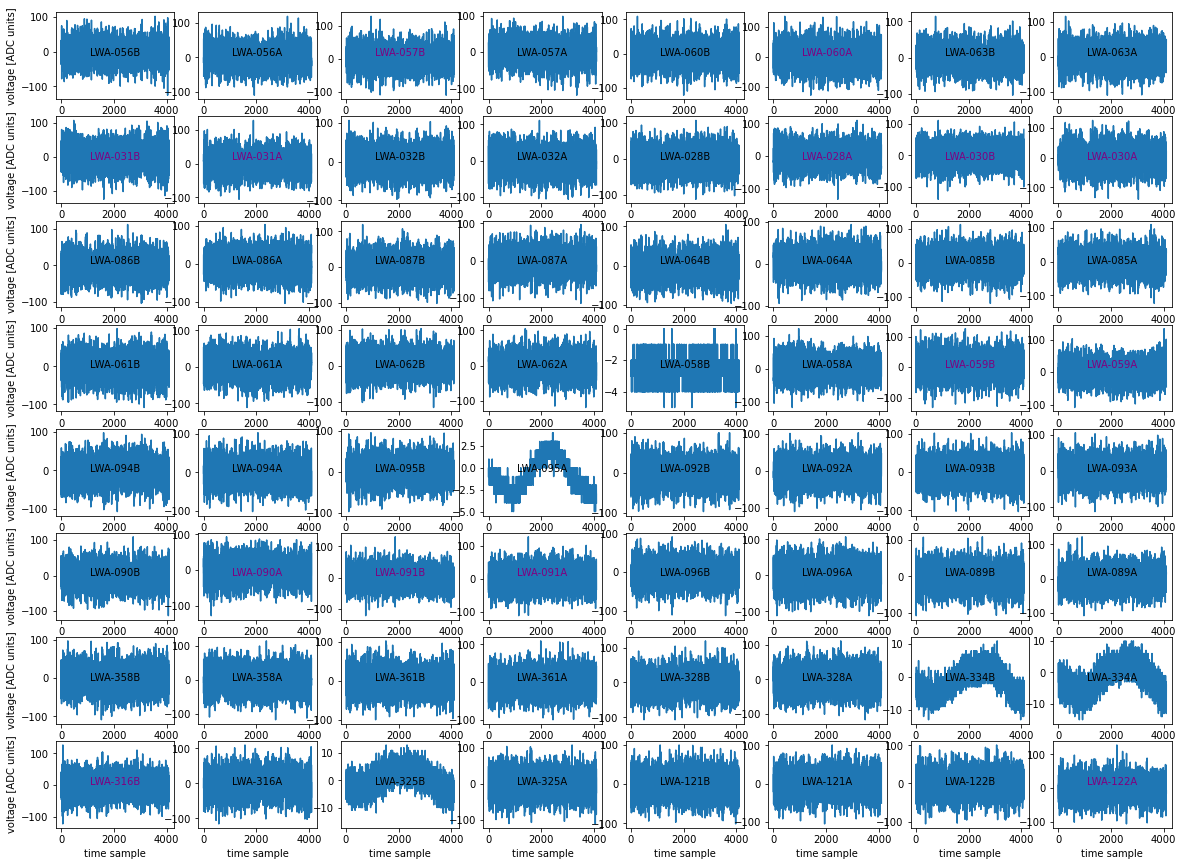

In [262]:
ploteventtimeseries_singlesnap(fname,125,0,boardnumber)

In [100]:
'''#for the first test, count how many antennas exceeded the threshold
print(count_directory('/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/testing2023Jan3/first_test/',300))'''

[18.  9. 27. 25. 21.  6.]


In [107]:
'''#for the second test, count how many antennas exceeded the threshold
counts=count_directory('/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/testing2023Jan3/second_test/',300)
print(counts)
print(len(counts))
plt.hist(counts,20)
plt.xlabel('Number of Antennas exceeding threshold')
plt.ylabel('Number of events')'''

# Single Board Threshold Scan Veto only

In [184]:
'''print(mapping.antpol_to_fpga('LWA-316','A')[1])
print(mapping.antpol_to_fpga('LWA-316','B')[1])
print(mapping.antpol_to_fpga('LWA-334','A')[1])
print(mapping.antpol_to_fpga('LWA-334','B')[1])'''

54
55
56
57


In [187]:
'''veto_power_thresh_initial=512
trigger_power_thresh=512
trigger_window=0
veto_window=int(round(1.97e8*1500/3e8,1)) #number of clock cycles to travel 1500 meters
antenna_number_thresh=0
veto_number_thresh_initial=0
core_roles_array=np.zeros(64,dtype=int)
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[int(mapping.antpol_to_fpga('LWA-329','A')[1])]=1
veto_roles_array[int(mapping.antpol_to_fpga('LWA-329','B')[1])]=1
veto_roles_array[int(mapping.antpol_to_fpga('LWA-357','A')[1])]=1
veto_roles_array[int(mapping.antpol_to_fpga('LWA-357','B')[1])]=1
print(veto_roles_array)

setup_coincidencer(casperbrd,trigger_power_thresh,
                          veto_power_thresh_initial,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh_initial,
                          core_roles_array,
                          veto_roles_array)


voltage_thresh=np.asarray([1,50,100,150,200,225,250,270,300,350,400,450,500,512])
ant_number_thresh=np.asarray([0,1,2,3])
vetos=np.zeros((len(voltage_thresh),len(ant_number_thresh)))
for m in range(len(ant_number_thresh)):
    setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',ant_number_thresh[m]) 
    for i in range(len(voltage_thresh)):
        t_v = voltage_thresh[i]
        setvalue(casperbrd,"veto_power_thresh","cr_registers.xlsx",int(t_v**2))
        time.sleep(2.75)  #have to wait for it to update
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        vetos[i,m]=veto_coincidence'''

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]


In [264]:
'''for m in range(len(ant_number_thresh)):
    plt.semilogy(voltage_thresh,vetos[:,m],'.-',label=str(ant_number_thresh[m])+ ' antennas')
plt.legend()
plt.xlabel('voltage threshold')
plt.ylabel('number of coincidences')'''

"for m in range(len(ant_number_thresh)):\n    plt.semilogy(voltage_thresh,vetos[:,m],'.-',label=str(ant_number_thresh[m])+ ' antennas')\nplt.legend()\nplt.xlabel('voltage threshold')\nplt.ylabel('number of coincidences')"

# Single Board Threshold Scan with Veto And Trigger


In [196]:
'''veto_power_thresh_initial=512
trigger_power_thresh_initial=512
trigger_window=int(round(1.97e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.97e8*1500/3e8,1)) #number of clock cycles to travel 1500 meters
antenna_number_thresh=4
veto_number_thresh=2
core_roles_array=np.ones(64,dtype=int)
core_roles_array[int(mapping.antpol_to_fpga('LWA-329','A')[1])]=0
core_roles_array[int(mapping.antpol_to_fpga('LWA-329','B')[1])]=0
core_roles_array[int(mapping.antpol_to_fpga('LWA-357','A')[1])]=0
core_roles_array[int(mapping.antpol_to_fpga('LWA-357','B')[1])]=0

veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[int(mapping.antpol_to_fpga('LWA-329','A')[1])]=1
veto_roles_array[int(mapping.antpol_to_fpga('LWA-329','B')[1])]=1
veto_roles_array[int(mapping.antpol_to_fpga('LWA-357','A')[1])]=1
veto_roles_array[int(mapping.antpol_to_fpga('LWA-357','B')[1])]=1

setup_coincidencer(casperbrd,trigger_power_thresh_initial,
                          veto_power_thresh_initial,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array)

#core_voltage_thresh=np.asarray([50,100,150])
#veto_voltage_thresh=np.asarray([50,100,150])
core_voltage_thresh=np.asarray([50,100,150,200,225,250,270,300,350,400,450,500,512])
veto_voltage_thresh=np.asarray([50,100,150,200,225,250,270,300,350,400,450,500,512])
vetos=np.zeros((len(core_voltage_thresh),len(veto_voltage_thresh)))
core_triggers=np.zeros((len(core_voltage_thresh),len(veto_voltage_thresh)))
final_triggers=np.zeros((len(core_voltage_thresh),len(veto_voltage_thresh)))

for m in range(len(core_voltage_thresh)):
    setvalue(casperbrd,'trigger_power_thresh','cr_registers.xlsx',ant_number_thresh[m]) 
    for i in range(len(veto_voltage_thresh)):
        t_v = voltage_thresh[i]
        setvalue(casperbrd,"veto_power_thresh","cr_registers.xlsx",int(t_v**2))
        internal_trigger_count1=getvalue(casperbrd,"internal_trigger_count","cr_registers.xlsx")
        time.sleep(2.75)  #have to wait for it to update
        internal_trigger_count2=getvalue(casperbrd,"internal_trigger_count","cr_registers.xlsx")
        triggers_leaving_block=(internal_trigger_count2-internal_trigger_count1)
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        vetos[i,m]=veto_coincidence
        core_triggers[i,m]=core_coincidence
        final_triggers[i,m]=triggers_leaving_block'''

IndexError: index 4 is out of bounds for axis 0 with size 4

In [263]:
'''
plt.figure()
plt.imshow(core_triggers)
plt.colorbar()

plt.figure()
plt.imshow(vetos)
plt.colorbar()

plt.figure()
plt.imshow(final_triggers)
plt.colorbar()'''

'\nplt.figure()\nplt.imshow(core_triggers)\nplt.colorbar()\n\nplt.figure()\nplt.imshow(vetos)\nplt.colorbar()\n\nplt.figure()\nplt.imshow(final_triggers)\nplt.colorbar()'

# Window length scan with long baselines-- revisit this later
When I first did this I was using the core coincidence counting even though these will eventually be veto antennas, because the veto counter was counting from the wrong place.

I think these antennas did not have delays to set, so interpreting this plot is still not very useful.

In [28]:
'''core_roles_array=np.zeros(64,dtype=int)
veto_roles_array=np.zeros(64,dtype=int)

#set veto roles for the two I'm interested in
#veto_roles_array[60]=1 #355A
#veto_roles_array[61]=1 #355B
#veto_roles_array[62]=1 #287A
#veto_roles_array[63]=1 #287B


setup_coincidencer(casperbrd,trigger_power_thresh,
                          veto_power_thresh,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array)


setvalue(casperbrd,'trigger_antennas1','cr_registers.xlsx',core_roles1)
setvalue(casperbrd,'trigger_antennas2','cr_registers.xlsx',core_roles2)
setvalue(casperbrd,'veto_antennas1','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_antennas2','cr_registers.xlsx',0)
setvalue(casperbrd,'veto_window','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,'antenna_number_thresh','cr_registers.xlsx',3) #require both polarizations of one antenna and at least one of the other
setvalue(casperbrd,'veto_number_thresh','cr_registers.xlsx',0) #not using for now
setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(300**2))

for i in range(3):
    distances=100*np.asarray([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    coincidences=np.zeros(len(distances))
    for d in range(len(distances)):
        w=int(round(1.97e8*distances[d]/3e8,1))
        setvalue(casperbrd,'trigger_window','cr_registers.xlsx',w) #number of clock cycles to travel 100 meters
        time.sleep(2.75)
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        coincidences[d]=core_coincidence  #have to divide by window length because it's counting the total overlap
    plt.plot(distances,coincidences)
plt.xlabel("Distance window")
plt.ylabel(" Proxy for Number of coincidences")'''

'core_roles_array=np.zeros(64,dtype=int)\ncore_roles_array[60]=1 #355A\ncore_roles_array[61]=1 #355B\ncore_roles_array[62]=1 #287A\ncore_roles_array[63]=1 #287B\ncore_roles1,core_roles2=packantennaroles(core_roles_array)\n\nsetvalue(casperbrd,\'trigger_antennas1\',\'cr_registers.xlsx\',core_roles1)\nsetvalue(casperbrd,\'trigger_antennas2\',\'cr_registers.xlsx\',core_roles2)\nsetvalue(casperbrd,\'veto_antennas1\',\'cr_registers.xlsx\',0)\nsetvalue(casperbrd,\'veto_antennas2\',\'cr_registers.xlsx\',0)\nsetvalue(casperbrd,\'veto_window\',\'cr_registers.xlsx\',0) #not using for now\nsetvalue(casperbrd,\'antenna_number_thresh\',\'cr_registers.xlsx\',3) #require both polarizations of one antenna and at least one of the other\nsetvalue(casperbrd,\'veto_number_thresh\',\'cr_registers.xlsx\',0) #not using for now\nsetvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(300**2))\n\nfor i in range(3):\n    distances=100*np.asarray([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])\n 

In [403]:
'''veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
'''

# Scratchwork